In [1]:
# ARGA performance on Kaggle
# 400 training tasks
# 180 seconds per task

In [2]:
import json
import time
from itertools import combinations, product
from inspect import signature
from queue import PriorityQueue

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mpl_colors
from matplotlib.ticker import MaxNLocator
import networkx as nx

print(nx.__version__)

3.3


In [3]:
train_ch_path = '../input/arc-prize-2024/arc-agi_training_challenges.json'
train_sol_path = '../input/arc-prize-2024/arc-agi_training_solutions.json'
eval_ch_path = '../input/arc-prize-2024/arc-agi_evaluation_challenges.json'
eval_sol_path = '../input/arc-prize-2024/arc-agi_evaluation_solutions.json'
test_path = '../input/arc-prize-2024/arc-agi_test_challenges.json'
sample_path = '../input/arc-prize-2024/sample_submission.json'

with open(train_ch_path, 'r', encoding='utf-8') as file:
    train_tasks = json.load(file)
with open(eval_ch_path, 'r', encoding='utf-8') as file:
    eval_tasks = json.load(file)
with open(test_path, 'r', encoding='utf-8') as file:
    test_tasks = json.load(file)

with open(train_sol_path, 'r', encoding='utf-8') as file:
    truth_t = json.load(file)
with open(eval_sol_path, 'r', encoding='utf-8') as file:
    truth_e = json.load(file)
truth = truth_t | truth_e

print(len(train_tasks), len(eval_tasks), len(test_tasks), len(truth))

400 400 100 800


In [4]:
'''Utils'''

cmap = mpl_colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = mpl_colors.Normalize(vmin=0, vmax=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

def plot_sample(in_pic, out_pic, predict=None):
    '''Standard task plotting'''
    def plot_pictures(pictures, labels):
        _, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures), 32))
        for i, (pic, label) in enumerate(zip(pictures, labels)):
            axs[i].xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True, min_n_ticks=1))
            axs[i].yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True, min_n_ticks=1))
            axs[i].imshow(np.array(pic), cmap=cmap, norm=norm)
            axs[i].set_title(label)
        plt.show()
    if predict is None:
        plot_pictures([in_pic, out_pic], ['Input', 'Output'])
    else:
        plot_pictures([in_pic, out_pic, predict], ['Input', 'Output', 'Predict'])

def plot_some(pictures, labels=None):
    '''Alternative task plotting'''
    if labels is None:
        labels = [str(i) for i in range(len(pictures))]
    _, axs = plt.subplots(2, int(len(pictures)/2), figsize=(len(pictures), 4.5))
    for ax, pic, label in zip(axs.flat, pictures, labels):
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5, integer=True, min_n_ticks=1))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True, min_n_ticks=1))
        ax.imshow(np.array(pic), cmap=cmap, norm=norm)
        ax.set_title(label)
    plt.show()

def set_types(tasks):
    '''Only type 1 is relevant'''
    for task in tasks.values():
        same_shape = all(np.shape(el['input']) == np.shape(el['output']) for el in task['train'])
        constant_shape = len({np.shape(el['output']) for el in task['train']}) == 1
        if same_shape:
            task['type'] = 1
        elif constant_shape:
            task['type'] = 2
        else:
            task['type'] = 3
    print(dict(zip(*np.unique([
        task['type'] for task in tasks.values()], return_counts=True))), '\n')

def process_task(task):
    '''Recoloring effort plus'''
    if 're' in task:
        return
    task['re'] = False
    uni_c = set()

    for not_pair in task['test']:
        ic = np.unique(not_pair['input']).tolist()
        uni_c |= set(ic)

    all_a = []
    all_b = []

    for pair in task['train']:
        input_colors, input_counts = np.unique(pair['input'], return_counts=True)
        output_colors = np.unique(pair['output'])
        a = list(zip(input_colors.tolist(), input_counts))
        a = tuple(x[0] for x in sorted(a, key=lambda x: x[1], reverse=True))
        all_a.append(a)
        all_b.append(tuple(output_colors.tolist()))

    uni_a = set(sum(all_a, ()))
    b_all_1 = np.all([len(x) == 1 for x in all_b])

    intersected = False
    for a, b in zip(all_a, all_b):
        ab = set.intersection(set(a), set(b))
        if len(ab) > 0:
            intersected = True
            break

    if len(task['test']) == 1 and uni_a != uni_c and intersected:
        task['re'] = True
        input_colors, input_counts = np.unique(task['test'][0]['input'], return_counts=True)
        c = list(zip(input_colors.tolist(), input_counts))
        c = tuple(x[0] for x in sorted(c, key=lambda x: x[1], reverse=True))

        colors = []
        commons = set.intersection(*[set(x) for x in all_a + [tuple(uni_c)]])
        for k in c:
            some_present = np.any([k in x for x in all_b])
            all_present = np.all([k in x for x in all_b])
            if (b_all_1 and k != 0) or (
                k not in commons and not all_present) or (
                    some_present and not all_present):
                colors.append(k)

        for i in range(len(task['train'])):
            raw = []
            for k in all_a[i]:
                some_present = np.any([k in x for x in all_b])
                all_present = np.all([k in x for x in all_b])
                if (b_all_1 and k != 0) or (
                    k not in commons and not all_present) or (
                        some_present and not all_present):
                    raw.append(k)

            unused = []
            for digit in range(1, 10):
                if digit not in commons | set(colors) | set(raw):
                    unused.append(digit)

            # Pixel counting
            ipc = task['train'][i]['input']
            opc = task['train'][i]['output']

            for j in range(len(raw)):
                if j < len(colors):
                    ipc = [[colors[j] + 10 if x == raw[j] else x for x in sub] for sub in ipc]
                    opc = [[colors[j] + 10 if x == raw[j] else x for x in sub] for sub in opc]
                else:
                    diff = j - len(colors)
                    if diff >= len(unused):
                        break
                    ipc = [[unused[diff] if (
                        x in colors and x == raw[j]) else x for x in sub] for sub in ipc]
                    opc = [[unused[diff] if (
                        x in colors and x == raw[j]) else x for x in sub] for sub in opc]
            ipc = [[x - 10 if x > 9 else x for x in sub] for sub in ipc]
            opc = [[x - 10 if x > 9 else x for x in sub] for sub in opc]
            task['train'][i]['input'] = ipc
            task['train'][i]['output'] = opc

    new_a = set()
    new_b = set()
    for pair in task['train']:
        ic = np.unique(pair['input']).tolist()
        oc = np.unique(pair['output']).tolist()
        new_a |= set(ic)
        new_b |= set(oc)
    task['all_colors'] = new_a | new_b | uni_c

    task['bgc'] = 0
    if any(0 not in x for x in all_a):
        new_a = []
        for pair in task['train']:
            input_colors, input_counts = np.unique(pair['input'], return_counts=True)
            a = list(zip(input_colors.tolist(), input_counts))
            a = tuple(x[0] for x in sorted(a, key=lambda x: x[1], reverse=True))
            new_a.append(a)
        firsts = [x[0] for x in new_a]
        if len(set(firsts)) == 1:
            task['bgc'] = firsts[0]

In [5]:
'''Part 1'''

class ARCGraph:
    '''(Graph) -> Image -> Task'''

    filter_ops = ["filter_by_nothing",
                  "filter_by_color",
                  "filter_by_size",
                  "filter_by_degree",
                  "filter_by_neighbor_color"]

    param_binding_ops = ["param_bind_neighbor_by_color",
                         "param_bind_node_by_color",
                         "param_bind_node_by_size",
                         "param_bind_node_by_shape"]

    param_values = {
        'flip_rotation': [('vertical', 0), ('horizontal', 0),
                          (None, 90), ('vertical', 90), ('horizontal', 90),
                          (None, 180), (None, 270)],
        'limit': ['max', 1, 2],
        'move_mode': ['touching', 'phasing', 'piercing', 'blasting'],
        'relative_position': ['source', 'target', 'middle'],
        'image_point': ['top', 'bottom', 'left', 'right',
                        'top_left', 'top_right', 'bottom_left', 'bottom_right'],
        'direction': ['up', 'down', 'left', 'right',
                      'up_left', 'up_right', 'down_left', 'down_right']}

    transformation_ops = {
        "nag": ["flip_rotate"],
        "nbccg": ["update_color", "move", "extend", "flip_rotate",
                  "add_border", "fill_rectangle", "hollow_rectangle",
                  "mirror", "insert"],
        "mcccg": ["swap_colors", "move", "add_border", "fill_rectangle",
                  "hollow_rectangle", "insert"],
        "nbvccg": ["update_color", "move"],
        "nbhccg": ["update_color", "move"]}

    dynamic_parameters = ["color",
                          "direction",
                          "image_point",
                          "mirror_axis"]

    def __init__(self, graph, name, image, abstraction=None):
        '''setup'''
        self.graph = graph
        self.image = image
        self.abstraction = abstraction
        if abstraction is None:
            self.name = name
        elif abstraction in name.split("_"):
            self.name = name
        else:
            self.name = name + "_" + abstraction
        if self.abstraction in image.multicolor_abstractions:
            self.is_multicolor = True
        else:
            self.is_multicolor = False

    # ------------------------------------- filters ------------------------------------------
    # filters take the form of filter(node, params), return true if node satisfies filter
    def filter_by_nothing(self, _):
        '''return true'''
        return True

    def filter_by_color(self, node, color, exclude: bool = False):
        """
        return true if node has given color
        if exclude, return true if node does not have given color
        """
        if self.is_multicolor and isinstance(color, int):
            if not exclude:
                return color in self.graph.nodes[node]["color"]
            return color not in self.graph.nodes[node]["color"]
        if color == "same":
            color = self.graph.nodes[node]["color"]
        if not exclude:
            return self.graph.nodes[node]["color"] == color
        return self.graph.nodes[node]["color"] != color

    def filter_by_size(self, node, size, exclude: bool = False):
        """
        return true if node has size equal to given size
        if exclude, return true if node does not have size equal to given size
        """
        if size == "max":
            size = self.get_attribute_max("size")
        elif size == "min":
            size = self.get_attribute_min("size")

        if size == "odd" and not exclude:
            return self.graph.nodes[node]["size"] % 2 != 0
        if size == "odd" and exclude:
            return self.graph.nodes[node]["size"] % 2 == 0

        if exclude:
            return self.graph.nodes[node]["size"] != size
        return self.graph.nodes[node]["size"] == size

    def filter_by_degree(self, node, degree, exclude: bool = False):
        """
        return true if node has degree equal to given degree
        if exclude, return true if node does not have degree equal to given degree
        """
        if not exclude:
            return self.graph.degree[node] == degree
        return self.graph.degree[node] != degree

    def filter_by_neighbor_color(self, node, color, exclude: bool = False):
        """
        return true if node has a neighbor of a given color
        if exclude, return true if node does not have a neighbor of a given color
        """
        if color == "same":
            color = self.graph.nodes[node]["color"]
        for neighbor in self.graph.neighbors(node):
            if not exclude:
                if self.graph.nodes[neighbor]["color"] == color:
                    return True
            elif exclude:
                if self.graph.nodes[neighbor]["color"] != color:
                    return True
        return False

    # --------------------------------- parameter binding functions --------------------------------
    # parameter binding takes the form of param_binding(node, params),
    # return node_2 if rel(node, node_2) and filter(node_2, params).
    # ex. neighbor of node with color blue

    def param_bind_neighbor_by_color(self, node, color, exclude: bool = False):
        """
        return the neighbor of node satisfying given color filter
        """
        if color == "same":
            color = self.graph.nodes[node]["color"]
        for neighbor in self.graph.neighbors(node):
            if self.filter_by_color(neighbor, color, exclude):
                return neighbor
        return None

    def param_bind_node_by_color(self, node, color, exclude: bool = False):
        """
        return any node satisfying given color filter
        """
        if color == "same":
            color = self.graph.nodes[node]["color"]
        for other_node in self.graph.nodes():
            if other_node != node and self.filter_by_color(other_node, color, exclude):
                return other_node
        return None

    def param_bind_node_by_size(self, size, exclude: bool = False):
        """
        return any node in graph satisfying given size filter
        """
        for node in self.graph.nodes():
            if self.filter_by_size(node, size, exclude):
                return node
        return None

    def param_bind_node_by_shape(self, node):
        """
        return any other node in the graph with the same shape as node
        """
        target_shape = self.get_shape(node)
        for param_bind_node in self.graph.nodes:
            if param_bind_node != node:
                candidate_shape = self.get_shape(param_bind_node)
                if candidate_shape == target_shape:
                    return param_bind_node
        return None

    # ------------------------------------------ transformations -----------------------------------
    def update_color(self, node, color):
        """
        update node color to given color
        """
        if color is None or color == 'same':
            return self
        self.graph.nodes[node]["color"] = color
        return self

    def swap_colors(self, node):
        '''swap if 2 colors in multicolor'''
        colors = self.graph.nodes[node]["color"]
        uni = np.unique(colors)
        if len(uni) == 2:
            for i, color in enumerate(colors):
                if color == uni[0]:
                    self.graph.nodes[node]["color"][i] = uni[1]
                else:
                    self.graph.nodes[node]["color"][i] = uni[0]
        return self

    def move(self, node, direction, limit, move_mode):
        """
        move node in a given direction until limit, another node, or the edge of the image
        """
        if limit == 'max':
            limit = 30
        delta_x = 0
        delta_y = 0
        if direction is None:
            return self
        if direction in ('up', 'up_left', 'up_right'):
            delta_y = -1
        elif direction in ('down', 'down_left', 'down_right'):
            delta_y = 1
        if direction in ('left', 'up_left', 'down_left'):
            delta_x = -1
        elif direction in ('right', 'up_right', 'down_right'):
            delta_x = 1

        for _ in range(limit):
            updated_nodes = []
            for sub_node in self.graph.nodes[node]["nodes"]:
                updated_nodes.append((sub_node[0] + delta_y, sub_node[1] + delta_x))
            if not self.check_inbound(updated_nodes):
                break
            if self.check_collision(node, updated_nodes):
                if move_mode == 'touching':
                    break
                if move_mode == 'phasing':
                    continue
            self.graph.nodes[node]["nodes"] = updated_nodes

        if move_mode == 'piercing':
            self.graph.nodes[node]['z'] -= 1
        if move_mode == 'blasting':
            self.graph.nodes[node]['z'] += 1
        return self

    def extend(self, node, direction, move_mode):
        """
        extend node in a given direction,
        if overlap is true, extend node even if it overlaps with another node
        if overlap is false, stop extending before it overlaps with another node
        """
        # How can I do colors?
        updated_sub_nodes = []
        delta_x = 0
        delta_y = 0
        if direction is None:
            return self
        if direction in ('up', 'up_left', 'up_right'):
            delta_y = -1
        elif direction in ('down', 'down_left', 'down_right'):
            delta_y = 1
        if direction in ('left', 'up_left', 'down_left'):
            delta_x = -1
        elif direction in ('right', 'up_right', 'down_right'):
            delta_x = 1

        for sub_node in self.graph.nodes[node]["nodes"]:
            sub_node_y = sub_node[0]
            sub_node_x = sub_node[1]
            updated_sub_nodes.append((sub_node_y, sub_node_x))

            for _ in range(30):
                sub_node_y += delta_y
                sub_node_x += delta_x
                if not self.check_inbound((sub_node_y, sub_node_x)):
                    break
                if self.check_collision(node, [(sub_node_y, sub_node_x)]):
                    if move_mode == 'touching':
                        break
                    if move_mode == 'phasing':
                        continue
                updated_sub_nodes.append((sub_node_y, sub_node_x))

        if move_mode == 'piercing':
            self.graph.nodes[node]['z'] -= 1
        if move_mode == 'blasting':
            self.graph.nodes[node]['z'] += 1
        self.graph.nodes[node]["nodes"] = list(set(updated_sub_nodes))
        self.graph.nodes[node]["size"] = len(updated_sub_nodes)
        return self

    def flip_rotate(self, node, flip_rotation):
        '''flip/rotate the node around its center point'''
        new_subnodes = []
        if flip_rotation[0] == 'vertical':
            max_y = max(subnode[0] for subnode in self.graph.nodes[node]["nodes"])
            min_y = min(subnode[0] for subnode in self.graph.nodes[node]["nodes"])
            for subnode in self.graph.nodes[node]["nodes"]:
                new_y = max_y - (subnode[0] - min_y)
                new_x = subnode[1]
                new_subnodes.append((new_y, new_x))
            self.graph.nodes[node]["nodes"] = new_subnodes
        elif flip_rotation[0] == 'horizontal':
            max_x = max(subnode[1] for subnode in self.graph.nodes[node]["nodes"])
            min_x = min(subnode[1] for subnode in self.graph.nodes[node]["nodes"])
            for subnode in self.graph.nodes[node]["nodes"]:
                new_y = subnode[0]
                new_x = max_x - (subnode[1] - min_x)
                new_subnodes.append((new_y, new_x))
            self.graph.nodes[node]["nodes"] = new_subnodes

        rotate_times = int(flip_rotation[1] / 90)
        max_y = max(subnode[0] for subnode in self.graph.nodes[node]["nodes"])
        min_y = min(subnode[0] for subnode in self.graph.nodes[node]["nodes"])
        max_x = max(subnode[1] for subnode in self.graph.nodes[node]["nodes"])
        min_x = min(subnode[1] for subnode in self.graph.nodes[node]["nodes"])
        for _ in range(rotate_times):
            new_nodes = []
            for sub_node in self.graph.nodes[node]["nodes"]:
                new_node = (min_y + (sub_node[1] - min_x),
                            min_x + (max_x - min_x - (sub_node[0] - min_y)))
                new_nodes.append(new_node)
            self.graph.nodes[node]["nodes"] = new_nodes
        return self

    def add_border(self, node, border_color):
        """
        add a border with thickness 1 and border_color around the given node
        """
        if border_color == "same":
            border_color = self.graph.nodes[node]["color"]
            if self.is_multicolor:
                border_color = self.graph.nodes[node]["color"][0]
        delta = [-1, 0, 1]
        border_pixels = []
        for sub_node in self.graph.nodes[node]["nodes"]:
            for x in delta:
                for y in delta:
                    border_pixel = (sub_node[0] + y, sub_node[1] + x)
                    if (border_pixel not in border_pixels
                        and not self.check_pixel_occupied(border_pixel)):
                        border_pixels.append(border_pixel)
        if len(border_pixels) == 0:
            return self
        new_node_id = self.generate_node_id(border_color)
        color = [border_color for _ in border_pixels] if self.is_multicolor else border_color
        self.graph.add_node(new_node_id, nodes=border_pixels,
                            color=color, size=len(border_pixels), z=0)
        return self

    def fill_rectangle(self, node, fill_color, overlap: bool):
        """
        fill the rectangle containing the given node with the given color
        if overlap is True, fill the rectangle even if it overlaps with other nodes
        """
        if fill_color == "same":
            fill_color = self.graph.nodes[node]["color"]
            if self.is_multicolor:
                fill_color = self.graph.nodes[node]["color"][0]
        all_x = [sub_node[1] for sub_node in self.graph.nodes[node]["nodes"]]
        all_y = [sub_node[0] for sub_node in self.graph.nodes[node]["nodes"]]
        min_x, min_y, max_x, max_y = min(all_x), min(all_y), max(all_x), max(all_y)
        unfilled_pixels = []
        for x in range(min_x, max_x + 1):
            for y in range(min_y, max_y + 1):
                pixel = (y, x)
                if pixel not in self.graph.nodes[node]["nodes"]:
                    if overlap:
                        unfilled_pixels.append(pixel)
                    elif not self.check_pixel_occupied(pixel):
                        unfilled_pixels.append(pixel)
        if len(unfilled_pixels) == 0:
            return self
        new_node_id = self.generate_node_id(fill_color)
        color = [fill_color for _ in unfilled_pixels] if self.is_multicolor else fill_color
        self.graph.add_node(new_node_id, nodes=unfilled_pixels,
                            color=color, size=len(unfilled_pixels), z=0)
        return self

    def hollow_rectangle(self, node, fill_color):
        """
        hollowing the rectangle containing the given node with the given color
        """
        if fill_color == "same":
            fill_color = self.graph.nodes[node]["color"]
            if self.is_multicolor:
                fill_color = self.graph.nodes[node]["color"][0]
        all_y = [n[0] for n in self.graph.nodes[node]["nodes"]]
        all_x = [n[1] for n in self.graph.nodes[node]["nodes"]]
        border_y = [min(all_y), max(all_y)]
        border_x = [min(all_x), max(all_x)]
        non_border_pixels = []
        new_subnodes = []
        for subnode in self.graph.nodes[node]["nodes"]:
            if subnode[0] in border_y or subnode[1] in border_x:
                new_subnodes.append(subnode)
            else:
                non_border_pixels.append(subnode)
        self.graph.nodes[node]["nodes"] = new_subnodes

        if fill_color == self.image.background_color or len(non_border_pixels) == 0:
            return self
        new_node_id = self.generate_node_id(fill_color)
        color = [fill_color for _ in non_border_pixels] if self.is_multicolor else fill_color
        self.graph.add_node(new_node_id, nodes=non_border_pixels,
                            color=color, size=len(non_border_pixels), z=0)
        return self

    def mirror(self, node, mirror_axis):
        """
        mirroring a node with respect to the given axis
        mirror_axis takes the form of (y, x) where one of y, x equals None to
        indicate the other being the axis of mirroring
        """
        if not isinstance(mirror_axis, tuple):
            return self
        if mirror_axis[1] is None and mirror_axis[0] is not None:
            axis = mirror_axis[0]
            new_subnodes = []
            for subnode in self.graph.nodes[node]["nodes"]:
                new_y = axis - (subnode[0] - axis)
                new_x = subnode[1]
                new_subnodes.append((new_y, new_x))
            if not self.check_collision(node, new_subnodes):
                self.graph.nodes[node]["nodes"] = new_subnodes
        elif mirror_axis[0] is None and mirror_axis[1] is not None:
            axis = mirror_axis[1]
            new_subnodes = []
            for subnode in self.graph.nodes[node]["nodes"]:
                new_y = subnode[0]
                new_x = axis - (subnode[1] - axis)
                new_subnodes.append((new_y, new_x))
            if not self.check_collision(node, new_subnodes):
                self.graph.nodes[node]["nodes"] = new_subnodes
        return self

    def insert(self, node, object_id, image_point, relative_position):
        """
        insert some pattern identified by object_id at some location,
        the location is defined as, the relative position between the given node and image_point
        for example, image_point=top, relative_position=middle will insert the pattern between
        the given node and the top of the image
        if object_id is -1, use the pattern given by node
        """
        if image_point is None:
            return self
        node_centroid = self.get_centroid(node)
        if not isinstance(image_point, tuple):
            if image_point == 'top':
                image_point = (0, node_centroid[1])
            elif image_point == 'bottom':
                image_point = (self.image.height - 1, node_centroid[1])
            elif image_point == 'left':
                image_point = (node_centroid[0], 0)
            elif image_point == 'right':
                image_point = (node_centroid[0], self.image.width - 1)
            elif image_point == 'top_left':
                image_point = (0, 0)
            elif image_point == 'top_right':
                image_point = (0, self.image.width - 1)
            elif image_point == 'bottom_left':
                image_point = (self.image.height - 1, 0)
            elif image_point == 'bottom_right':
                image_point = (self.image.height - 1, self.image.width - 1)

        if object_id == -1:
            # special id for dynamic objects, which uses the given nodes as objects
            node_object = self.graph.nodes[node]
        else:
            node_object = self.image.task.static_objects_for_insertion[self.abstraction][object_id]

        target_point = self.get_point_from_relative_position(
            node_centroid, image_point, relative_position)
        if target_point is None:
            return self

        # Different version: respecting grid boundaries
        object_centroid = self.get_centroid(node_object["nodes"])
        subnodes_coords = []
        for subnode in node_object["nodes"]:
            delta_y = subnode[0] - object_centroid[0]
            delta_x = subnode[1] - object_centroid[1]
            subnodes_coords.append((target_point[0] + delta_y, target_point[1] + delta_x))
        if len(subnodes_coords) == 0:
            return self

        new_node_id = self.generate_node_id(node_object["color"])
        self.graph.add_node(new_node_id, nodes=subnodes_coords, color=node_object["color"],
                            size=len(subnodes_coords), z=0)
        return self

    # ------------------------------------- utils ------------------------------------------
    def remove_node(self, node):
        """
        remove a node from the graph
        """
        self.graph.remove_node(node)
        return self

    def get_attribute_max(self, attribute_name):
        """
        get the maximum value of the given attribute
        """
        if len(self.graph.nodes) == 0:
            return None
        return max(data[attribute_name] for node, data in self.graph.nodes(data=True))

    def get_attribute_min(self, attribute_name):
        """
        get the minimum value of the given attribute
        """
        if len(self.graph.nodes) == 0:
            return None
        return min(data[attribute_name] for node, data in self.graph.nodes(data=True))

    def get_color(self, node):
        """
        return the color of the node
        """
        if isinstance(node, list):
            return [self.graph.nodes[node_i]["color"] for node_i in node]
        return self.graph.nodes[node]["color"]

    def check_inbound(self, pixels):
        """
        check if given pixels are all within the image boundary
        """
        if not isinstance(pixels, list):
            pixels = [pixels]
        for pixel in pixels:
            y, x = pixel
            if x < 0 or y < 0 or x >= self.image.width or y >= self.image.height:
                return False
        return True

    def check_collision(self, node_id, pixels_list=None):
        """
        check if given pixels_list collide with other nodes in the graph
        node_id is used to retrieve pixels_list if not given
        node_id is also used so that only collision with other nodes are detected
        """
        if pixels_list is None:
            pixels_set = set(self.graph.nodes[node_id]["nodes"])
        else:
            pixels_set = set(pixels_list)
        for node, data in self.graph.nodes(data=True):
            if len(set(data["nodes"]) & pixels_set) != 0 and node != node_id:
                return True
        return False

    def check_pixel_occupied(self, pixel):
        """
        check if a pixel is occupied by any node in the graph
        """
        for _, data in self.graph.nodes(data=True):
            if pixel in data["nodes"]:
                return True
        return False

    def get_shape(self, node):
        """
        given a node, get the shape of the node
        the shape of the node is defined using its pixels shifted so that the top left is 0,0
        """
        sub_nodes = self.graph.nodes[node]["nodes"]
        if len(sub_nodes) == 0:
            return set()
        min_x = min(sub_node[1] for sub_node in sub_nodes)
        min_y = min(sub_node[0] for sub_node in sub_nodes)
        return {(y - min_y, x - min_x) for y, x in sub_nodes}

    def get_centroid(self, node):
        '''get the centroid of the node pixels'''
        if isinstance(node, tuple):
            pixels = self.graph.nodes[node]["nodes"]
        else:
            pixels = node
        size = len(pixels)
        if size == 0:
            return (0, 0)
        center_y = (sum(n[0] for n in pixels) + size // 2) // size
        center_x = (sum(n[1] for n in pixels) + size // 2) // size
        return (center_y, center_x)

    def get_relative_position(self, node_1, node_2):
        """
        direction of where node 2 is relative to node 1,
        what is the direction of going from 1 to 2
        """
        nodes_1 = self.graph.nodes[node_1]["nodes"]
        nodes_2 = self.graph.nodes[node_2]["nodes"]
        if len(nodes_1) == 0 or len(nodes_2) == 0:
            return None

        y1, x1 = zip(*nodes_1)
        y2, x2 = zip(*nodes_2)
        c1 = (sum(x1) / len(nodes_1), sum(y1) / len(nodes_1))
        c2 = (sum(x2) / len(nodes_2), sum(y2) / len(nodes_2))

        for sub_node_1 in nodes_1:
            for sub_node_2 in nodes_2:
                if sub_node_1[0] == sub_node_2[0]:
                    if abs(c1[0] - c2[0]) < abs(c1[1] - c2[1]):
                        continue
                    if sub_node_1[1] < sub_node_2[1]:
                        return 'right'
                    if sub_node_1[1] > sub_node_2[1]:
                        return 'left'
                elif sub_node_1[1] == sub_node_2[1]:
                    if abs(c1[0] - c2[0]) > abs(c1[1] - c2[1]):
                        continue
                    if sub_node_1[0] < sub_node_2[0]:
                        return 'down'
                    if sub_node_1[0] > sub_node_2[0]:
                        return 'up'
        return None

    def get_mirror_axis(self, node_1, node_2):
        """
        get the axis to mirror node_1 with given node_2
        """
        if not self.graph.has_edge(node_1, node_2):
            return (None, None)
        node_2_centroid = self.get_centroid(node_2)
        if self.graph.edges[node_1, node_2]["direction"] == "vertical":
            return (node_2_centroid[0], None)
        return (None, node_2_centroid[1])

    def get_point_from_relative_position(self, filtered_point, relative_point, relative_position):
        """
        get the point to insert new node given
        filtered_point: the centroid of the filtered node
        relative_point: the centroid of the target node, or static point such as (0,0)
        relative_position: the relative position of the filtered_point to the relative_point
        """
        if relative_position == 'source':
            return filtered_point
        elif relative_position == 'target':
            return relative_point
        elif relative_position == 'middle':
            y = (filtered_point[0] + relative_point[0]) // 2
            x = (filtered_point[1] + relative_point[1]) // 2
            return (y, x)
        return None

    # ------------------------------------------ apply -----------------------------------
    def apply(self, abstraction, filters, filter_params, transformation, transformation_params):
        """
        perform a full operation on the abstracted graph
        1. apply filters to get a list of nodes to transform
        2. apply param binding to the filtered nodes to retrieve parameters for the transformation
        3. apply transformation to the nodes
        """
        # Cleaning (a stable version produces no empty nodes)
        empty = []
        for node, data in self.graph.nodes(data=True):
            if data['size'] == 0:
                empty.append(node)
        for node in empty:
            self.remove_node(node)

        transformed_nodes = {}
        for node in self.graph.nodes():
            if self.apply_filters(node, filters, filter_params):
                params = self.apply_param_binding(node, transformation_params)
                transformed_nodes[node] = params
        for node, params in transformed_nodes.items():
            self.apply_transformation(node, transformation, params)

        if abstraction == 'bug':
            print('lol')

    def apply_filters(self, node, filters, filter_params):
        """
        given filters and a node, return True if node satisfies all filters
        """
        satisfy = True
        for filter_, filter_param in zip(filters, filter_params):
            satisfy = satisfy and getattr(self, filter_)(node, **filter_param)
        return satisfy

    def apply_param_binding(self, node, transformation_params):
        """
        handle dynamic parameters: if a dictionary is passed as a parameter value, this means
        the parameter value needs to be retrieved from the parameter-bound nodes during the search
        example: set param "color" to the color of the neighbor with size 1
        """
        transformation_params_retrieved = {}
        for param_key, param_value in transformation_params[0].items():
            transformation_params_retrieved[param_key] = param_value

            if isinstance(param_value, dict):
                param_bind_function = param_value["filters"][0]
                param_bind_function_params = param_value["filter_params"][0]
                target_node = getattr(self, param_bind_function)(node, **param_bind_function_params)
                if target_node is None:
                    transformation_params_retrieved[param_key] = None
                    continue

                #  retrieve value, ex. color of the neighbor with size 1
                if param_key == "color":
                    target_value = self.get_color(target_node)
                elif param_key == "direction":
                    target_value = self.get_relative_position(node, target_node)
                elif param_key == "image_point":
                    target_value = self.get_centroid(target_node)
                elif param_key == "mirror_axis":
                    target_value = self.get_mirror_axis(node, target_node)
                else:
                    raise ValueError("Unsupported dynamic parameter")

                transformation_params_retrieved[param_key] = target_value

        return transformation_params_retrieved

    def apply_transformation(self, node, transformation, transformation_params):
        """
        apply transformation to a node
        currently only allows one transformation
        """
        getattr(self, transformation[0])(node, **transformation_params)

    # ------------------------------------------ meta utils -----------------------------------
    def copy(self):
        """
        return a copy of this ARCGraph object
        """
        return ARCGraph(self.graph.copy(), self.name, self.image, self.abstraction)

    def generate_node_id(self, color):
        """
        find the next available id for a given color,
        ex: if color=1 and there are already (1,0) and (1,1), return (1,2)
        """
        if isinstance(color, list):  # multi-color cases
            color = color[0]
        max_id = 0
        for node in self.graph.nodes():
            if node[0] == color:
                max_id = max(max_id, node[1])
        return (color, max_id + 1)

    def get_pixel_grid(self):
        '''get the 2D-grid projection of the current graph state'''
        grid = np.full(self.image.image_size, self.image.background_color)
        mc = self.abstraction in self.image.multicolor_abstractions
        points = {}
        for _, data in self.graph.nodes(data=True):
            for i, node in enumerate(data["nodes"]):
                if self.check_inbound(node):
                    color = data["color"][i] if mc else data["color"]
                    if node in points:
                        points[node].append((color, data['z']))
                    else:
                        points[node] = [(color, data['z'])]
        for node, colors in points.items():
            colors.sort(key=lambda x: x[1], reverse=True)
            grid[node] = colors[0][0]
        return grid

In [6]:
'''Part 2'''

class Image:
    '''Graph -> (Image) -> Task'''
    # Some abstractions were retired
    # Abstraction order matters for short runs
    abstractions = ["nag", "nbccg", "mcccg", "nbvccg", "nbhccg"]
    abstraction_getters = {
        "nag": "get_no_abstraction_graph",
        "nbccg": "get_non_black_connected_components_graph",
        "mcccg": "get_multicolor_connected_components_graph",
        "nbvccg": "get_non_background_vertical_connected_components_graph",
        "nbhccg": "get_non_background_horizontal_connected_components_graph"}
    multicolor_abstractions = ["nag", "mcccg"]

    def __init__(self, task, grid=None, width=None, height=None, graph=None, name="image"):
        """
        an image represents a 2D-grid of pixels
        the coordinate system follows the convention of 0,0
        being the top left pixel of the image
        :param grid: a grid that represent the image
        :param width: if a grid is not given, determines the width of the graph
        :param height: if a grid is not given, determines the height of the graph
        :param graph: if a networkx graph is given, use it directly as the graph
        """
        self.task = task
        self.all_colors = task.all_colors

        self.name = name
        self.grid = grid
        self.background_color = task.bgc

        if not grid and not graph:
            # create a graph with default color
            self.width = width
            self.height = height
            self.image_size = (height, width)
            self.graph = nx.grid_2d_graph(height, width)
            nx.set_node_attributes(self.graph, 0, "color")
        elif graph:
            self.width = max(node[1] for node in graph.nodes()) + 1
            self.height = max(node[0] for node in graph.nodes()) + 1
            self.image_size = (self.height, self.width)
            self.graph = graph
        else:
            # create a graph with the color in given grid
            self.width = len(grid[0])
            self.height = len(grid)
            self.image_size = (self.height, self.width)
            self.graph = nx.grid_2d_graph(self.height, self.width)
            for r, row in enumerate(grid):
                for c, color in enumerate(row):
                    self.graph.nodes[r, c]["color"] = color

        self.corners = {(0, 0), (0, self.width - 1), (self.height - 1, 0),
                        (self.height - 1, self.width - 1)}

    def add_edges(self, graph, bg=0):
        """
        add edges between the abstracted nodes
        """
        for node_1, node_2 in combinations(graph.nodes, 2):
            nodes_1 = graph.nodes[node_1]["nodes"]
            nodes_2 = graph.nodes[node_2]["nodes"]
            y1, x1 = zip(*nodes_1)
            y2, x2 = zip(*nodes_2)
            c1 = (sum(x1) / len(nodes_1), sum(y1) / len(nodes_1))
            c2 = (sum(x2) / len(nodes_2), sum(y2) / len(nodes_2))

            for n1 in nodes_1:
                for n2 in nodes_2:
                    if n1[0] == n2[0]:  # two nodes on the same row
                        for column_index in range(min(n1[1], n2[1]) + 1, max(n1[1], n2[1])):
                            if self.graph.nodes[n1[0], column_index]["color"] != bg:
                                break
                        else:
                            if abs(c1[0] - c2[0]) > abs(c1[1] - c2[1]):
                                graph.add_edge(node_1, node_2, direction="horizontal")
                                break
                    elif n1[1] == n2[1]:  # two nodes on the same column
                        for row_index in range(min(n1[0], n2[0]) + 1, max(n1[0], n2[0])):
                            if self.graph.nodes[row_index, n1[1]]["color"] != bg:
                                break
                        else:
                            if abs(c1[0] - c2[0]) < abs(c1[1] - c2[1]):
                                graph.add_edge(node_1, node_2, direction="vertical")
                                break
                else:
                    continue
                break

    def get_no_abstraction_graph(self, graph=None):
        """
        return an abstracted graph where a node is defined as:
        the entire graph as one multi-color node
        """
        if not graph:
            graph = self.graph
        nag = nx.Graph()

        sub_nodes = []
        sub_nodes_color = []
        for node in graph.nodes():
            sub_nodes.append(node)
            sub_nodes_color.append(graph.nodes[node]["color"])
        nag.add_node((0, 0), nodes=sub_nodes, color=sub_nodes_color, size=len(sub_nodes), z=0)

        return ARCGraph(nag, self.name, self, "nag")

    def get_non_black_connected_components_graph(self, graph=None):
        """
        return an abstracted graph where a node is defined as:
        a group of adjacent pixels of the same color in the original graph,
        excluding background color
        """
        if not graph:
            graph = self.graph
        nbccg = nx.Graph()

        for color in self.all_colors:
            if color == self.background_color:
                continue
            color_nodes = (node for node, data in graph.nodes(
                data=True) if data.get("color") == color)
            color_subgraph = graph.subgraph(color_nodes)
            color_connected_components = nx.connected_components(color_subgraph)
            for i, component in enumerate(color_connected_components):
                nbccg.add_node((color, i), nodes=list(component),
                               color=color, size=len(component), z=0)

        self.add_edges(nbccg, self.background_color)
        return ARCGraph(nbccg, self.name, self, "nbccg")

    def get_multicolor_connected_components_graph(self, graph=None):
        """
        return an abstracted graph where a node is defined as:
        a group of adjacent pixels of any non-background color in the original graph
        """
        if not graph:
            graph = self.graph
        mcccg = nx.Graph()

        non_background_nodes = [node for node, data in graph.nodes(
            data=True) if data["color"] != self.background_color]
        color_subgraph = graph.subgraph(non_background_nodes)
        multicolor_connected_components = nx.connected_components(color_subgraph)

        for i, component in enumerate(multicolor_connected_components):
            sub_nodes = []
            sub_nodes_color = []
            for node in component:
                sub_nodes.append(node)
                sub_nodes_color.append(graph.nodes[node]["color"])
            mcccg.add_node((len(sub_nodes), i), nodes=sub_nodes,
                           color=sub_nodes_color, size=len(sub_nodes), z=0)

        self.add_edges(mcccg, self.background_color)
        return ARCGraph(mcccg, self.name, self, "mcccg")

    def get_non_background_vertical_connected_components_graph(self, graph=None):
        """
        return an abstracted graph where a node is defined as:
        a group of vertically adjacent pixels of the same color in the original graph,
        excluding background color
        """
        if not graph:
            graph = self.graph
        nbvccg = nx.Graph()

        for color in self.all_colors:
            color_connected_components = []
            if color == self.background_color:
                continue
            for column in range(self.width):
                color_nodes = (node for node, data in graph.nodes(data=True) if
                               node[1] == column and data.get("color") == color)
                color_subgraph = graph.subgraph(color_nodes)
                color_connected_components.extend(list(nx.connected_components(color_subgraph)))
            for i, component in enumerate(color_connected_components):
                nbvccg.add_node((color, i), nodes=component, color=color, size=len(component), z=0)

        self.add_edges(nbvccg, self.background_color)
        return ARCGraph(nbvccg, self.name, self, "nbvccg")

    def get_non_background_horizontal_connected_components_graph(self, graph=None):
        """
        return an abstracted graph where a node is defined as:
        a group of horizontally adjacent pixels of the same color in the original graph,
        excluding background color
        """
        if not graph:
            graph = self.graph
        nbhccg = nx.Graph()

        for color in self.all_colors:
            color_connected_components = []
            if color == self.background_color:
                continue
            for row in range(self.height):
                color_nodes = (node for node, data in graph.nodes(data=True) if
                               node[0] == row and data.get("color") == color)
                color_subgraph = graph.subgraph(color_nodes)
                color_connected_components.extend(list(nx.connected_components(color_subgraph)))
            for i, component in enumerate(color_connected_components):
                nbhccg.add_node((color, i), nodes=component, color=color, size=len(component), z=0)

        self.add_edges(nbhccg, self.background_color)
        return ARCGraph(nbhccg, self.name, self, "nbhccg")

In [7]:
class PriorityItem:
    """
    storing information of a node in the search tree,
    the sequence of filters and transformations is stored as data,
    instead of the abstracted graphs themselves
    """
    def __init__(self, data, abstraction, priority, depth=0, wide=False):
        self.data = data
        self.abstraction = abstraction
        self.priority = priority
        self.depth = depth
        self.wide = wide

    def __lt__(self, other):
        if self.wide:
            if self.depth == other.depth:
                if self.priority == other.priority:
                    return len(json.dumps(self.data)) < len(json.dumps(other.data))
                return self.priority < other.priority
            return self.depth < other.depth

        if self.priority == other.priority:
            if self.depth == other.depth:
                return len(json.dumps(self.data)) < len(json.dumps(other.data))
            return self.depth < other.depth
        return self.priority < other.priority

In [8]:
'''Part 3'''

class Task:
    '''Graph -> Image -> (Task)'''
    def __init__(self, name, data):
        """
        contains all information related to an ARC task
        """
        self.task_id = name
        self.data = data
        self.test = False
        self.solved = False
        self.all_colors = set()
        self.bgc = 0
        self.start_time = 0

        # input/output images
        self.train_inputs = []
        self.train_outputs = []
        self.test_inputs = []
        self.test_outputs = []

        # abstracted graphs from input/output images:
        # dictionaries of ARCGraphs, where the keys are the abstraction names and
        # values are lists of ARCGraphs with the abstraction name for all inputs/outputs
        self.abstracted_input_graphs = {}
        self.abstracted_output_graphs = {}
        self.abstracted_input_graphs_original = {}
        self.abstracted_output_graphs_original = {}

        # metadata tracking
        self.total_nodes_explored = 0
        self.total_unique_frontier_nodes = 0

        # attributes used for search
        self.shared_frontier = None  # whether to use shared or abstraction frontiers
        self.constrained = None  # whether to do constraint acquisition or not
        self.time_limit = None  # time limit for search
        self.verbose = None  # print search progress
        self.wide = None  # depth vs score priority
        self.abstraction = None  # which type of abstraction the search is currently working with
        self.static_objects_for_insertion = {}  # static objects for the "insert" transformation
        self.object_sizes = {}  # object sizes to use for filters
        self.object_degrees = {}  # object degrees to use for filters
        self.transformation_ops = {}  # a dictionary of transformation operations
        self.frontier_hash = {}  # used for checking if a resulting image is already found
        self.tabu_list = {}  # temporarily disabling expanding frontier for a specific abstraction
        self.tabu_list_waiting = {}  # list of nodes to be added back to frontier
        self.current_best_scores = {}  # tracking the current best score for each abstraction
        self.current_best_score = float("inf")  # the current best score
        self.current_best_apply_call = None  # apply call that produces the current best solution
        self.current_best_abstraction = None  # abstraction that produces the current best solution
        self.frontier = None  # a priority queue of frontier nodes to be expanded

        self.base_filter = {'filters': ['filter_by_nothing'], 'filter_params': [{}]}

        self.load_task(data)

    def load_task(self, data):
        '''load the task'''
        self.all_colors = data['all_colors']
        self.bgc = data['bgc']

        for i, data_pair in enumerate(data['train']):
            self.train_inputs.append(
                Image(self, grid=data_pair['input'], name=f'{self.task_id}_{i+1}_train_in'))
            self.train_outputs.append(
                Image(self, grid=data_pair['output'], name=f'{self.task_id}_{i+1}_train_out'))
        for i, data_pair in enumerate(data['test']):
            self.test_inputs.append(
                Image(self, grid=data_pair['input'], name=f'{self.task_id}_{i+1}_test_in'))
            if self.task_id in truth:
                self.test_outputs.append(
                    Image(self, grid=truth[self.task_id][i], name=f'{self.task_id}_{i+1}_test_out'))
            else:
                self.test = True

    def solve(self, time_limit=100, shared_frontier=True, constrained=True,
              verbose=False, wide=False, stats=None):
        """
        solve for a solution, yes
        :param shared_frontier: whether the search uses a shared frontier between abstractions
        :param time_limit: maximum time allowed for search in seconds
        :param constrained: whether constraint acquisition is used
        """
        self.time_limit = time_limit
        self.shared_frontier = shared_frontier
        self.constrained = constrained
        self.verbose = verbose
        self.wide = wide

        # frontier for search, each item is a PriorityItem object
        if shared_frontier:
            self.frontier = PriorityQueue()
        else:
            self.frontier = {}  # maintain a separate frontier for each abstraction

        print(f"Solving: {self.task_id}")

        self.start_time = time.time()

        # initialize frontier
        stop_search = self.initialize_frontier()

        # main search loop
        while not stop_search:
            if self.shared_frontier:
                stop_search = self.search_shared_frontier()
            else:
                stop_search = self.search_separate_frontier()

        predictions = []
        no_error = False

        # apply to test images
        for i, input_image in enumerate(self.test_inputs):
            solution = [[0, 0], [0, 0]]
            if self.current_best_abstraction is None:
                predictions.append(solution)
                print("No solution at all!")
                continue

            abstracted_graph = getattr(input_image, Image.abstraction_getters[
                self.current_best_abstraction])()
            for call in self.current_best_apply_call:
                abstracted_graph.apply(**call)

            sol_grid = abstracted_graph.get_pixel_grid()

            # check if the solution gets the correct test output
            error = 0
            if not self.test:
                error = np.sum(np.not_equal(sol_grid, self.test_outputs[i].grid))
                if error == 0:
                    no_error = True
                    print('The solution is correct!')
                else:
                    print(f"The best solution predicted {error} "
                          f"out of {sol_grid.size} pixels incorrectly")
                if self.solved or no_error:
                    print('Steps:', len(self.current_best_apply_call),
                          '| Sol:', self.current_best_apply_call)

            if self.solved:
                solution = sol_grid.tolist()
            predictions.append(solution)

        print()
        if stats is not None and self.task_id in stats:
            seconds = time.time() - self.start_time
            stats[self.task_id] += f' {seconds:6.2f} {str(self.solved):5} {no_error}'

        return predictions

    def timeout(self):
        '''time out the task'''
        return time.time() - self.start_time > self.time_limit

    def complete(self, message='none'):
        '''display results'''
        messages = {'solved': 'Solution found!',
                    'timeout': 'Solution not found due to time limit reached!',
                    'empty': 'Solution not found due to empty search space!',
                    'none': 'Solution not found due to unknown reasons!'}
        print(messages[message])
        print(f'Abstraction: {self.current_best_abstraction} | '
              f'Best score: {self.current_best_score} | '
              f'Runtime: {time.time() - self.start_time:g}')
        return True

    def update_score(self, frontier_node):
        '''track stats'''
        if frontier_node.priority < self.current_best_score:
            self.current_best_score = frontier_node.priority
            self.current_best_apply_call = frontier_node.data
            self.current_best_abstraction = self.abstraction
            if frontier_node.priority == 0:
                self.solved = True

    def initialize_frontier(self):
        """
        initialize frontier
        :return: True if a solution is found during initialization
        or time limit has been reached, False otherwise
        """
        if self.verbose:
            print("Initializing frontier")

        for abstraction in Image.abstractions:
            # It's time to stop
            if self.timeout():
                return self.complete('timeout')

            # specify the current abstraction
            self.abstraction = abstraction

            # initialize individual frontiers if abstractions do not share one
            if not self.shared_frontier:
                self.frontier[abstraction] = PriorityQueue()

            # initialize additional attributes used in search
            self.current_best_scores[abstraction] = float("inf")
            self.tabu_list[abstraction] = 0
            self.tabu_list_waiting[abstraction] = []
            self.frontier_hash[abstraction] = set()

            # produce the abstracted graphs for input output images using the current abstraction
            # these are the 'original' abstracted graphs that will not be updated
            self.abstracted_input_graphs_original[abstraction] = [
                getattr(input_image, Image.abstraction_getters[
                    abstraction])() for input_image in self.train_inputs]
            self.abstracted_output_graphs_original[abstraction] = [
                getattr(output_image, Image.abstraction_getters[
                    abstraction])() for output_image in self.train_outputs]

            # keep a list of transformation ops that we modify
            # based on constraint acquisition results
            self.transformation_ops[abstraction] = ARCGraph.transformation_ops[abstraction]

            # constraint acquisition (global)
            if self.constrained:
                self.constraints_acquisition_global()

            # look for static objects to insert
            # if insert transformation is not pruned by constraint acquisition
            self.get_static_inserted_objects(abstraction)

            # get the list of object sizes and degrees
            self.get_static_object_attributes(abstraction)

            # initiate frontier with dummy node and expand it
            # (representing doing nothing to the input image)
            frontier_node = PriorityItem([], abstraction, float("inf"), float("inf"), self.wide)

            sol_node = self.expand_frontier(frontier_node)
            if sol_node is not None:
                self.update_score(sol_node)
                return self.complete('solved')

            if self.shared_frontier:
                if self.frontier.empty():
                    continue
                frontier_node = self.frontier.queue[0]
            else:
                if self.frontier[abstraction].empty():
                    continue
                frontier_node = self.frontier[abstraction].queue[0]

            if frontier_node.priority < self.current_best_scores[abstraction]:
                self.current_best_scores[abstraction] = frontier_node.priority

            self.update_score(frontier_node)

            if self.timeout():
                return self.complete('timeout')

        print('Init complete')
        return False

    def search_shared_frontier(self):
        """
        perform one iteration of search for a solution using a shared frontier
        :return: True if a solution is found or time limit has been reached, False otherwise
        """
        if self.frontier.empty():
            if self.verbose:
                print('Tabu reset!')
            for abstraction in self.tabu_list:
                # put the nodes from the waiting list back into frontier
                for node in self.tabu_list_waiting[abstraction]:
                    self.frontier.put(node)
                self.tabu_list_waiting[abstraction] = []
                self.tabu_list[abstraction] = 0

        if self.frontier.empty():
            return self.complete('empty')

        frontier_node = self.frontier.get(False)

        # if this abstraction is on tabu list, collect the nodes
        if self.tabu_list[frontier_node.abstraction] > 0:
            self.tabu_list_waiting[frontier_node.abstraction].append(frontier_node)
            return False
        # if this abstraction is not on tabu list, but has a worse score than before,
        # explore it and put it on tabu list
        if frontier_node.priority >= self.current_best_scores[frontier_node.abstraction]:
            self.tabu_list[frontier_node.abstraction] = 1
        else:
            self.current_best_scores[frontier_node.abstraction] = frontier_node.priority

        self.abstraction = frontier_node.abstraction
        if self.verbose:
            print(f"Exploring frontier node with score {frontier_node.priority} "
                  f"at depth {frontier_node.depth} "
                  f"with abstraction {self.abstraction}")

        self.update_score(frontier_node)
        sol_node = self.expand_frontier(frontier_node)
        if sol_node is not None:
            self.update_score(sol_node)
            return self.complete('solved')

        if self.timeout():
            return self.complete('timeout')

        return False

    def search_separate_frontier(self):
        """
        perform one iteration of search for a solution using a multiple frontiers
        :return: True if a solution is found or time limit has been reached, False otherwise
        """
        proceed = False

        for abstraction in Image.abstractions:
            self.abstraction = abstraction

            if self.frontier[self.abstraction].empty():
                continue
            # if this abstraction is on tabu list, explore something else
            if self.tabu_list[self.abstraction] > 0:
                self.tabu_list[self.abstraction] = 0
                proceed = True
                continue

            proceed = True
            frontier_node = self.frontier[self.abstraction].get()

            # if this abstraction is not on tabu list, but has a worse score than before,
            # explore it and put it on tabu list
            if frontier_node.priority >= self.current_best_scores[self.abstraction]:
                self.tabu_list[self.abstraction] = 1
            else:
                self.current_best_scores[self.abstraction] = frontier_node.priority

            if self.verbose:
                print(f"Exploring frontier node with score {frontier_node.priority} "
                      f"at depth {len(frontier_node.data)} "
                      f"with abstraction {self.abstraction}")

            self.update_score(frontier_node)
            sol_node = self.expand_frontier(frontier_node)
            if sol_node is not None:
                self.update_score(sol_node)
                return self.complete('solved')

            if self.timeout():
                return self.complete('timeout')

        if not proceed:
            return self.complete('empty')

        return False

    def expand_frontier(self, frontier_node):
        """
        expand one frontier node
        """
        if self.verbose:
            print(f"Expanding frontier node with abstraction {self.abstraction}")
        # up to date abstracted graphs
        self.abstracted_input_graphs[self.abstraction] = []
        for abstracted_input_graph in self.abstracted_input_graphs_original[self.abstraction]:
            abstracted_input = abstracted_input_graph.copy()
            for apply_call in frontier_node.data:
                # apply the transformation to the abstracted graph
                abstracted_input.apply(**apply_call)
            self.abstracted_input_graphs[self.abstraction].append(abstracted_input)

        apply_calls = self.get_candidate_transformations()

        if self.verbose:
            print(f"Number of new candidate nodes: {len(apply_calls)}")
        added_nodes = 0

        for apply_call in apply_calls:
            if self.timeout():
                break
            self.total_nodes_explored += 1
            cumulated_apply_calls = frontier_node.data.copy()
            cumulated_apply_calls.append(apply_call)
            # Apply the new step to the precalculated graphs
            apply_call_score = self.calculate_score(apply_call)

            if apply_call_score == -1:
                continue
            if apply_call_score >= self.current_best_scores[self.abstraction]:
                continue

            added_nodes += 1
            priority_item = PriorityItem(cumulated_apply_calls,
                                         self.abstraction,
                                         apply_call_score,
                                         len(cumulated_apply_calls),
                                         self.wide)
            # Done
            if apply_call_score == 0:
                return priority_item

            if self.abstraction == 'nag':
                continue

            if self.shared_frontier:
                self.frontier.put(priority_item)
            else:
                self.frontier[self.abstraction].put(priority_item)

        if self.verbose:
            print(f"Number of new nodes added to Frontier: {added_nodes}")
        self.total_unique_frontier_nodes += added_nodes
        return None

    def get_candidate_transformations(self):
        """
        generate candidate transformations, return list of full operations candidates
        """
        filters = self.get_candidate_filters()
        all_apply_calls = []
        if self.constrained:
            transformation_ops = self.get_transformations()
        else:
            transformation_ops = self.transformation_ops[self.abstraction]

        # Many-way combinatorial madness!
        # This is the thing to address!
        for transform_op in transformation_ops:
            if self.timeout():
                break
            sig = signature(getattr(ARCGraph, transform_op))
            params = [x for x in sig.parameters.keys() if x not in ('self', 'node')]
            for filter_call in filters:
                if self.timeout():
                    break
                generated_params = self.generate_parameters(sig, filter_call)
                for item in product(*generated_params):
                    param_vals = {}
                    for param, value in zip(params, item):
                        param_vals[param] = value
                    # dont need deep copy here since we are not modifying existing entries
                    apply_call = {"abstraction": self.abstraction}
                    apply_call |= filter_call.copy()
                    apply_call["transformation"] = [transform_op]
                    apply_call["transformation_params"] = [param_vals]
                    all_apply_calls.append(apply_call)
        return all_apply_calls

    def get_candidate_filters(self):
        """
        return list of candidate filters
        """
        if self.abstraction == 'nag':
            return [self.base_filter]

        all_apply_filter_calls = []  # final list of filter calls
        filtered_nodes_all = []  # use this list to avoid filters that return the same set of nodes

        for filter_op in ARCGraph.filter_ops:
            # first, we generate all possible values for each parameter
            sig = signature(getattr(ARCGraph, filter_op))
            params = [x for x in sig.parameters.keys() if x not in ('self', 'node')]
            generated_params = []
            for param in sig.parameters.values():
                param_name = param.name
                if param_name in ("self", "node"):
                    continue

                if param_name == "color":
                    generated_params.append(["same"] + [c for c in self.all_colors])
                elif param_name == "size":
                    generated_params.append(["min", "max", "odd"] +
                        [s for s in self.object_sizes[self.abstraction]])
                elif param_name == "degree":
                    generated_params.append([d for d in self.object_degrees[self.abstraction]])
                elif param.annotation == bool:
                    generated_params.append([True, False])
                elif param_name in ARCGraph.param_values:
                    generated_params.append([p for p in ARCGraph.param_values[param_name]])

            # then, we combine all generated values to get all possible combinations of parameters
            for item in product(*generated_params):
                param_vals = {}
                for param, value in zip(params, item):
                    param_vals[param] = value
                candidate_filter = {"filters": [filter_op],
                                    "filter_params": [param_vals]}

                #  do not include if the filter result in empty set of nodes
                # (this will be the majority of filters)
                filtered_nodes = []
                for abstracted_input_graph in self.abstracted_input_graphs[self.abstraction]:
                    filtered_nodes_i = []
                    for node in abstracted_input_graph.graph.nodes():
                        if abstracted_input_graph.apply_filters(node, **candidate_filter):
                            filtered_nodes_i.append(node)
                    filtered_nodes.extend(filtered_nodes_i)
                filtered_nodes.sort()
                # does not result in empty or duplicate set of nodes
                if len(filtered_nodes) > 0 and filtered_nodes not in filtered_nodes_all:
                    filtered_nodes_all.append(filtered_nodes)
                    all_apply_filter_calls.append(candidate_filter)

        if self.verbose:
            print(f"Applicable filters: {len(all_apply_filter_calls)}")
        return all_apply_filter_calls

    def generate_parameters(self, transform_sig, filter_call):
        """
        given filter nodes and a transformation, generate parameters for the transformation
        example: given filters for red nodes and move,
        return [up, down, left, right, get_relative_position(red nodes, blue neighbors), ...]
        :param filter_call: the specific apply filter call to get the nodes
        :param all_calls: all apply filter calls, this is used to generate the dynamic parameters
        :param transform_sig: signature for a transformation
        :return: parameters to be passed to the transformation
        """
        generated_params = []
        for param in transform_sig.parameters.values():
            param_name = param.name
            if param_name in ("self", "node"):
                continue
            # first we generate the static values
            if param_name in ("color", "fill_color", "border_color"):
                all_possible_values = ["same"] + [c for c in self.all_colors]
            elif param_name == "object_id":
                all_possible_values = [-1] + [i for i in range(len(
                    self.static_objects_for_insertion[self.abstraction]))]
            elif param_name in ARCGraph.param_values:
                all_possible_values = [p for p in ARCGraph.param_values[param_name]]
            elif param.annotation == bool:
                all_possible_values = [True, False]
            else:
                all_possible_values = []

            # then we add dynamic values for parameters
            if param_name in ARCGraph.dynamic_parameters:
                all_possible_values = self.generate_dynamic_parameters(
                    all_possible_values, filter_call)

            generated_params.append(all_possible_values)
        return generated_params

    def generate_dynamic_parameters(self, all_possible_values, filter_call):
        """
        generate the dynamic part
        """
        param_nodes_all = []
        # the filters that define the dynamic parameter values,
        # has their own parameters generated_filter_params
        for param_binding_op in ARCGraph.param_binding_ops:
            sig = signature(getattr(ARCGraph, param_binding_op))
            generated_filter_params = []
            for deep_param in sig.parameters.values():
                deep_param_name = deep_param.name
                if deep_param_name in ("self", "node"):
                    continue
                if deep_param_name == "color":
                    generated_filter_params.append(["same"] + [c for c in self.all_colors])
                elif deep_param_name == "size":
                    generated_filter_params.append(["min", "max", "odd"] +
                        [s for s in self.object_sizes[self.abstraction]])
                elif deep_param_name == "degree":
                    generated_filter_params.append(
                        [d for d in self.object_degrees[self.abstraction]])
                elif deep_param.annotation == bool:
                    generated_filter_params.append([True, False])
                elif deep_param_name in ARCGraph.param_values:
                    generated_filter_params.append(
                        [p for p in ARCGraph.param_values[deep_param_name]])

            for item in product(*generated_filter_params):
                param_vals = {}
                for i, param in enumerate(list(sig.parameters)[2:]):
                    param_vals[sig.parameters[param].name] = item[i]

                param_nodes = []
                for abstracted_input_graph in self.abstracted_input_graphs[self.abstraction]:
                    param_nodes_i = []
                    for node in abstracted_input_graph.graph.nodes():
                        if abstracted_input_graph.apply_filters(node, **filter_call):
                            param_node = getattr(
                                abstracted_input_graph, param_binding_op)(node, **param_vals)
                            if param_node is not None:
                                param_nodes_i.append(param_node)
                    param_nodes.extend(param_nodes_i)
                param_nodes.sort()
                if len(param_nodes) > 0 and param_nodes not in param_nodes_all:
                    param_nodes_all.append(param_nodes)
                    all_possible_values.append({"filters": [param_binding_op],
                                                "filter_params": [param_vals]})
        return all_possible_values

    def get_search_score(self, focused='', index=0):
        '''estimate combinatorial complexity of the task (experimental)'''
        self.time_limit = 300
        self.start_time = time.time()
        all_combos = {}
        for abstraction in Image.abstractions:
            self.abstraction = abstraction
            self.abstracted_input_graphs_original[abstraction] = [
                getattr(input_image, Image.abstraction_getters[
                    abstraction])() for input_image in self.train_inputs]
            self.abstracted_output_graphs_original[abstraction] = [
                getattr(output_image, Image.abstraction_getters[
                    abstraction])() for output_image in self.train_outputs]
            self.abstracted_input_graphs[
                abstraction] = self.abstracted_input_graphs_original[abstraction]
            self.abstracted_output_graphs[
                abstraction] = self.abstracted_output_graphs_original[abstraction]
            self.transformation_ops[abstraction] = ARCGraph.transformation_ops[abstraction]
            self.constraints_acquisition_global()
            self.get_static_inserted_objects(abstraction)
            self.get_static_object_attributes(abstraction)

            combos = self.get_candidate_transformations()
            all_combos[abstraction] = len(combos)

            def plot_6(images, a, call):
                for ti, to in images:
                    graph = getattr(ti, Image.abstraction_getters[a])()
                    graph.apply(**call)
                    solution = graph.get_pixel_grid()
                    diff_io = np.not_equal(ti.grid, to.grid)
                    diff_is = np.not_equal(ti.grid, solution)
                    diff_so = np.not_equal(solution, to.grid)
                    plot_some([ti.grid, diff_io, to.grid, diff_is, solution, diff_so],
                              ['Input', 'Diff IO', 'Output', 'Diff IS', 'Sol', 'Diff SO'])

            if abstraction == focused:
                print(abstraction, index, combos[index])
                print('Train:', len(self.train_inputs))
                plot_6(zip(self.train_inputs, self.train_outputs), abstraction, combos[index])
                print('Test:', len(self.test_inputs))
                plot_6(zip(self.test_inputs, self.test_outputs), abstraction, combos[index])

        return all_combos

    def calculate_score(self, apply_call):
        """
        calculate the total score across all training examples for a given apply call,
        hash the apply call by using it as a key to the cache
        """
        all_recon = []
        for abstracted_input_graph in self.abstracted_input_graphs[self.abstraction]:
            abstracted_input = abstracted_input_graph.copy()
            abstracted_input.apply(**apply_call)
            reconstructed = abstracted_input.get_pixel_grid()
            all_recon.append(reconstructed.tolist())

        hash_string = json.dumps(all_recon, separators=('', ''))
        if hash_string in self.frontier_hash[self.abstraction]:
            return -1
        self.frontier_hash[self.abstraction].add(hash_string)

        score = 0
        for i, output in enumerate(self.train_outputs):
            score += np.sum(np.not_equal(all_recon[i], output.grid))

        return score

    def check_sol(self, sol, mode='all', plot=False):
        '''check solutions independently (experimental)'''
        abstraction = sol[0]['abstraction']
        # Required for some operations
        self.abstracted_input_graphs_original[abstraction] = [
            getattr(input_image, Image.abstraction_getters[
                abstraction])() for input_image in self.train_inputs]
        self.abstracted_output_graphs_original[abstraction] = [
            getattr(output_image, Image.abstraction_getters[
                abstraction])() for output_image in self.train_outputs]
        self.transformation_ops[abstraction] = ARCGraph.transformation_ops[abstraction]
        self.get_static_inserted_objects(abstraction)
        self.get_static_object_attributes(abstraction)

        def check(images):
            for input_image, output_image in images:
                graph = getattr(input_image, Image.abstraction_getters[abstraction])()
                for call in sol:
                    graph.apply(**call)
                solution = graph.get_pixel_grid()

                error = np.sum(np.not_equal(solution, output_image.grid))
                if error == 0:
                    print('The solution is correct!')
                else:
                    print(f'The solution predicted {error} '
                          f'out of {solution.size} pixels incorrectly')
                if plot:
                    plot_sample(input_image.grid, output_image.grid, solution)

        if mode != 'test':
            print('Train:', len(self.train_inputs))
            check(zip(self.train_inputs, self.train_outputs))
        if mode != 'train':
            print('Test:', len(self.test_inputs))
            check(zip(self.test_inputs, self.test_outputs))

    def constraints_acquisition_global(self):
        """
        find the constraints that all nodes in the instance must follow
        """
        no_movements = True
        for i, image in enumerate(self.train_inputs):
            for node, data in image.graph.nodes(data=True):
                if (data["color"] != image.background_color
                    and self.train_outputs[i].graph.nodes[
                        node]["color"] == image.background_color) or (
                            data["color"] == image.background_color
                            and self.train_outputs[i].graph.nodes[
                                node]["color"] != image.background_color):
                    no_movements = False
        no_new_objects = True
        for i, abstracted_output_graph in enumerate(
            self.abstracted_output_graphs_original[self.abstraction]):
            abstracted_input_nodes = self.abstracted_input_graphs_original[
                self.abstraction][i].graph.nodes()
            for abstracted_node, data in abstracted_output_graph.graph.nodes(data=True):
                if abstracted_node not in abstracted_input_nodes:
                    no_new_objects = False
                    break
        if no_movements:
            excluded = ["move", "fill_rectangle", "add_border", "insert"]
            self.transformation_ops[self.abstraction] = [
                t for t in self.transformation_ops[self.abstraction] if t not in excluded]
        elif no_new_objects:
            self.transformation_ops[self.abstraction] = [
                t for t in self.transformation_ops[self.abstraction] if t not in ["insert"]]

    def constraints_acquisition_local(self):
        """
        given an apply_filter_call, find the set of constraints that
        the nodes returned by the apply_filter_call must satisfy.
        these are called local constraints as they apply only to the nodes
        that satisfy the filter
        """
        list_of_rules = ["color_equal", "position_equal", "size_equal"]
        found_constraints = []
        for rule in list_of_rules:
            all_satisfied = True
            for index in range(len(self.train_inputs)):
                satisfied = self.constraints_param_satisfaction(rule, index)
                all_satisfied = all_satisfied and satisfied
            if all_satisfied:
                found_constraints.append(rule)
        return found_constraints

    def constraints_param_satisfaction(self, rule, index):
        """
        given condition and rule, first generate the sequence using the condition
        then transform the sequence into the expected format for the constraint
        :param condition: {'filters': ['filter_nodes_by_color'],
          'filter_params': [{'color': 0, 'exclude': True}]}
        :param rule: "rule_name"
        :param index: training instance index
        """
        input_abs = self.abstracted_input_graphs[self.abstraction][index]
        output_abs = self.abstracted_output_graphs_original[self.abstraction][index]

        input_nodes = []
        for node in input_abs.graph.nodes():
            input_nodes.append(node)

        output_nodes = []
        for node in output_abs.graph.nodes():
            output_nodes.append(node)

        if rule == "color_equal":
            input_sequence = [input_abs.graph.nodes[node]["color"] for node in input_nodes]
            output_sequence = [output_abs.graph.nodes[node]["color"] for node in output_nodes]

        elif rule == "position_equal":
            input_sequence = []
            output_sequence = []
            for node in input_nodes:
                input_sequence.extend(subnode for subnode in input_abs.graph.nodes[node]["nodes"])
            for node in output_nodes:
                output_sequence.extend(subnode for subnode in output_abs.graph.nodes[node]["nodes"])

        elif rule == "size_equal":
            input_sequence = [input_abs.graph.nodes[node]["size"] for node in input_nodes]
            output_sequence = [output_abs.graph.nodes[node]["size"] for node in output_nodes]

        input_sequence.sort()
        output_sequence.sort()

        return input_sequence == output_sequence

    def get_transformations(self):
        """
        given a set of constraints that must be satisfied,
        return a set of transformations that do not violate them
        """
        constraints = self.constraints_acquisition_local()
        transformations = self.transformation_ops[self.abstraction]
        excluded = []
        for constraint in constraints:
            if constraint == "color_equal":
                excluded.extend(["update_color"])
            elif constraint == "position_equal":
                excluded.extend(["move", "extend"])
            elif constraint == "size_equal":
                excluded.extend(["extend"])
        transformations = [t for t in transformations if t not in excluded]
        return transformations

    def get_static_inserted_objects(self, abstraction):
        """
        populate self.static_objects_for_insertion,
        which contains all static objects detected in the images
        """
        self.static_objects_for_insertion[abstraction] = []
        if 'insert' not in self.transformation_ops[abstraction]:
            return
        existing_objects = []
        for i, abstracted_output_graph in enumerate(
            self.abstracted_output_graphs_original[abstraction]):
            abstracted_input_nodes = self.abstracted_input_graphs_original[
                abstraction][i].graph.nodes()
            for abstracted_node, data in abstracted_output_graph.graph.nodes(data=True):
                if abstracted_node not in abstracted_input_nodes:
                    new_object = data.copy()
                    min_x = min(subnode[1] for subnode in new_object["nodes"])
                    min_y = min(subnode[0] for subnode in new_object["nodes"])
                    adjusted_subnodes = []
                    for subnode in new_object["nodes"]:
                        adjusted_subnodes.append((subnode[0] - min_y, subnode[1] - min_x))
                    adjusted_subnodes.sort()
                    if adjusted_subnodes not in existing_objects:
                        existing_objects.append(adjusted_subnodes)
                        self.static_objects_for_insertion[abstraction].append(new_object)

    def get_static_object_attributes(self, abstraction):
        """
        populate self.object_sizes and self.object_degrees,
        which contains all sizes and degrees of existing objects
        """
        self.object_sizes[abstraction] = set()
        self.object_degrees[abstraction] = set()
        for abs_graph in self.abstracted_input_graphs_original[abstraction]:
            for _, size in abs_graph.graph.nodes(data="size"):
                self.object_sizes[abstraction].add(size)
            for _, degree in abs_graph.graph.degree():
                self.object_degrees[abstraction].add(degree)

In [9]:
def solve_task(name, task, limit=10, stats=None):
    task = Task(name, task)
    return task.solve(time_limit=limit, stats=stats)

def solve_all(tasks, limit=10):
    start_time = time.time()
    predictions = {}
    stats = {}
    index = 0
    count = 0
    for name, task in tasks.items():
        index += 1
        if task['type'] == 1:
            duration = time.time() - start_time
            hh = int(duration / 3600)
            mm = int(duration % 3600 / 60)
            ss = int(duration % 60)
            print(f'{int(100*index/len(tasks))}% | {index}/{len(tasks)} [{hh:02}:{mm:02}:{ss:02}]')
            count += 1
            stats[name] = f'{count:3} {index:3} {name}'
            process_task(task)
            prediction = solve_task(name, task, limit, stats)
        else:
            prediction = [[[0, 0], [0, 0]]] * len(task['test'])
        predictions[name] = prediction
    return predictions, stats

def run_main(tasks, limit=10):
    set_types(tasks)
    predictions, stats = solve_all(tasks, limit)
    submission = {}
    for name, task in tasks.items():
        submission[name] = []
        for i in range(len(task['test'])):
            submission[name].append(
                {'attempt_1': predictions[name][i],
                 'attempt_2': [[0, 0], [0, 0]]})

    with open('submission.json', 'w', encoding='utf-8') as sub_file:
        json.dump(submission, sub_file)
    return stats

def observe_results(tasks, stats=None):
    with open('submission.json', 'r', encoding='utf-8') as file:
        submission = json.load(file)

    predictions = {}
    for name, attempts in submission.items():
        predictions[name] = []
        for i in range(len(attempts)):
            predictions[name].append(attempts[i]['attempt_1'])

    scores = []
    for name, prediction in predictions.items():
        score = [0 if np.shape(true_grid) != np.shape(grid) else int(
            np.equal(true_grid, grid).all()) for true_grid, grid in zip(truth[name], prediction)]
        scores.append(score)

    solved = [any(score) for score in scores]
    percent_solved = 100 * sum(solved) / len(solved)
    print(f'Solved: {sum(solved)} from {len(solved)} ({percent_solved:g}%)', end='\n\n')

    if stats is not None:
        summary = {'tn': 0, 'fn': 0, 'fp': 0, 'tp': 0}
        print('  # IDX  ID/Name   Time Train  Test')
        for entry in stats.values():
            print(entry)
            if entry.find('False False') > 0:
                summary['tn'] += 1
            if entry.find('False True') > 0:
                summary['fn'] += 1
            if entry.find('True  False') > 0:
                summary['fp'] += 1
            if entry.find('True  True') > 0:
                summary['tp'] += 1
        print('', summary, '', sep='\n')

    count = 0
    index = 0
    for name, prediction, right in zip(predictions.keys(), predictions.values(), solved):
        task = tasks[name]
        index += 1
        if prediction != [[[0, 0], [0, 0]]] * len(task['test']):
            count += 1
            print(count, index, name, right)
            for i in range(len(task['test'])):
                plot_sample(task['test'][i]['input'], truth[name][i], prediction[i])

In [10]:
# Task control
the_stats = None
the_tasks = train_tasks
time_limit = 180

In [11]:
the_stats = run_main(the_tasks, time_limit)

{1: 262, 2: 76, 3: 62} 

0% | 2/400 [00:00:00]
Solving: 00d62c1b
Init complete
Solution not found due to time limit reached!
Abstraction: mcccg | Best score: 19 | Runtime: 180.008
The best solution predicted 33 out of 400 pixels incorrectly

1% | 4/400 [00:03:00]
Solving: 025d127b
Init complete
Solution found!
Abstraction: nbccg | Best score: 0 | Runtime: 13.9271
The solution is correct!
Steps: 2 | Sol: [{'abstraction': 'nbccg', 'filters': ['filter_by_degree'], 'filter_params': [{'degree': 1, 'exclude': True}], 'transformation': ['move'], 'transformation_params': [{'direction': 'right', 'limit': 1, 'move_mode': 'touching'}]}, {'abstraction': 'nbccg', 'filters': ['filter_by_degree'], 'filter_params': [{'degree': 4, 'exclude': False}], 'transformation': ['move'], 'transformation_params': [{'direction': 'left', 'limit': 1, 'move_mode': 'touching'}]}]

1% | 5/400 [00:03:13]
Solving: 045e512c
Init complete
Solution not found due to time limit reached!
Abstraction: nbccg | Best score: 68 | R

Solved: 63 from 400 (15.75%)

  # IDX  ID/Name   Time Train  Test
  1   2 00d62c1b 180.01 False False
  2   4 025d127b  13.93 True  True
  3   5 045e512c 180.01 False False
  4   7 05269061 180.23 False False
  5   8 05f2a901   0.06 True  True
  6   9 06df4c85 180.01 False False
  7  10 08ed6ac7  68.37 False False
  8  11 09629e4f 180.01 False False
  9  12 0962bcdd 180.00 False False
 10  13 0a938d79 180.01 False False
 11  15 0ca9ddb6 180.00 False False
 12  16 0d3d703e 180.00 False False
 13  17 0dfd9992 180.04 False False
 14  18 0e206a2e 180.01 False False
 15  20 11852cab 180.52 False False
 16  23 150deff5  34.92 False False
 17  24 178fcbfb  24.79 True  False
 18  25 1a07d186 180.01 False False
 19  27 1b60fb0c 180.00 False False
 20  28 1bfc4729 171.45 True  True
 21  30 1caeab9d 180.00 False False
 22  32 1e0a9b12  20.39 True  True
 23  33 1e32b0e9 180.01 False False
 24  34 1f0c79e5 180.00 False False
 25  35 1f642eb9 180.00 False False
 26  37 1f876c06 180.00 False False
 2

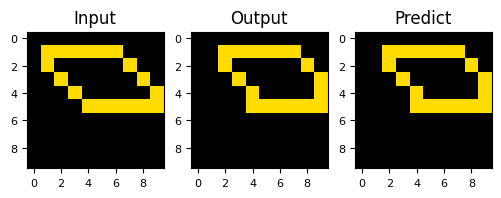

2 8 05f2a901 True


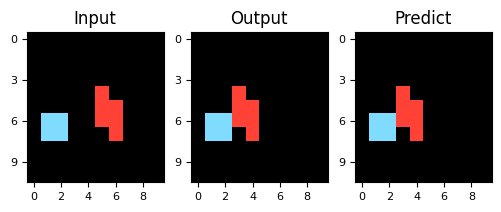

3 24 178fcbfb False


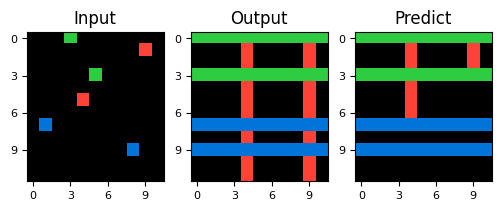

4 28 1bfc4729 True


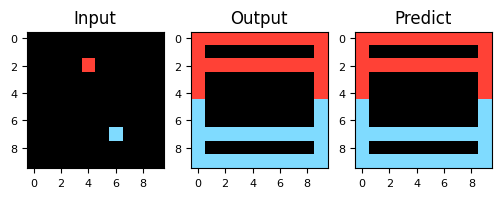

5 32 1e0a9b12 True


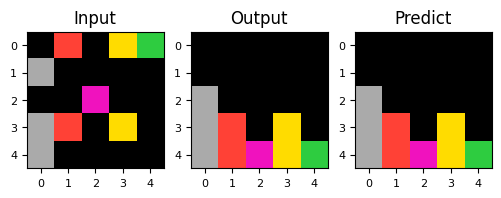

6 41 22168020 True


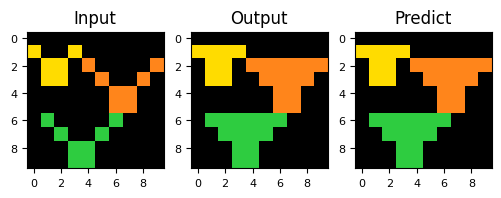

7 45 22eb0ac0 True


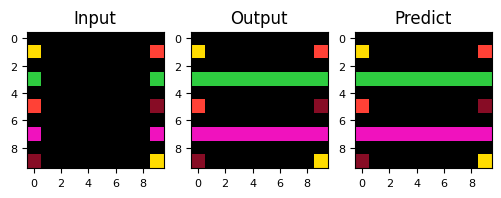

8 51 25d487eb True


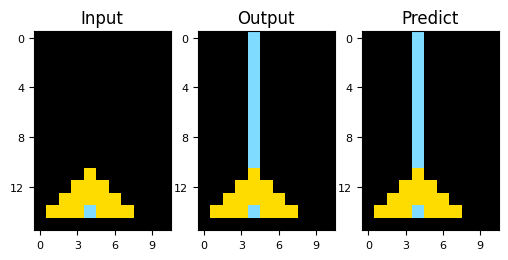

9 52 25d8a9c8 True


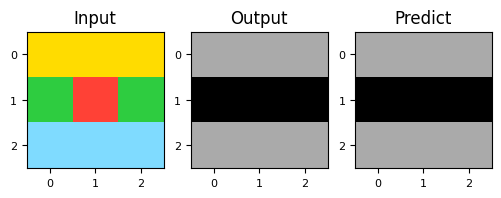

10 53 25ff71a9 True


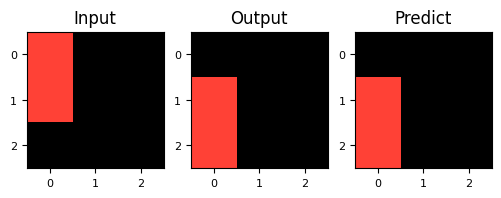

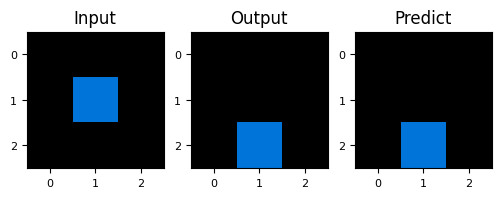

11 55 272f95fa False


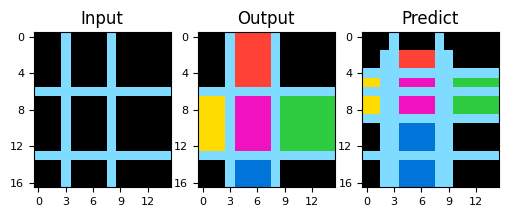

12 60 29c11459 False


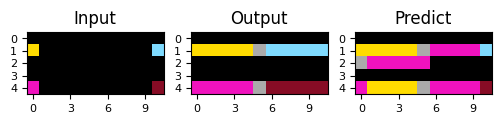

13 64 2c608aff True


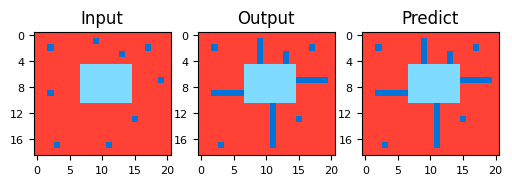

14 73 3618c87e True


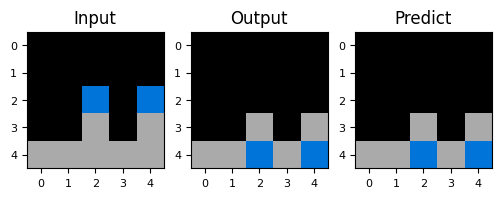

15 78 3906de3d True


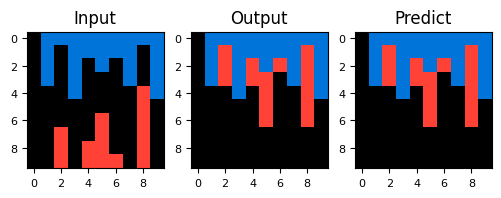

16 81 3aa6fb7a True


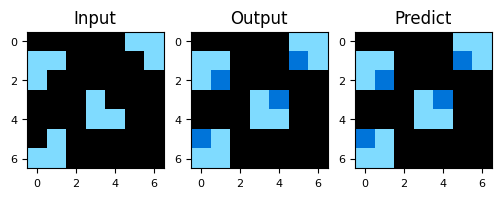

17 84 3bd67248 True


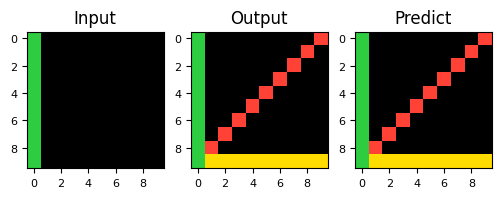

18 85 3bdb4ada False


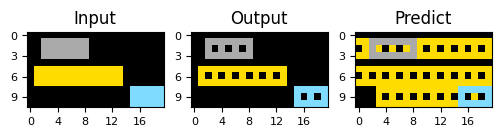

19 87 3c9b0459 True


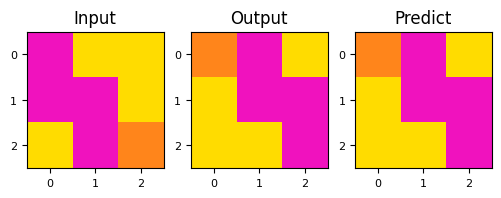

20 92 40853293 False


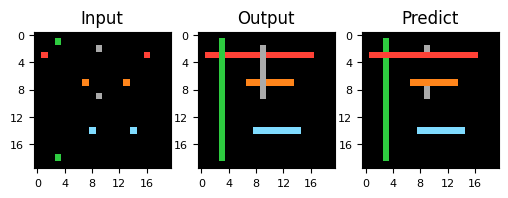

21 94 41e4d17e True


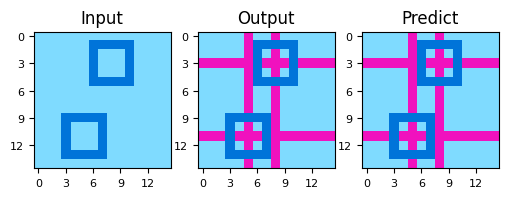

22 95 4258a5f9 True


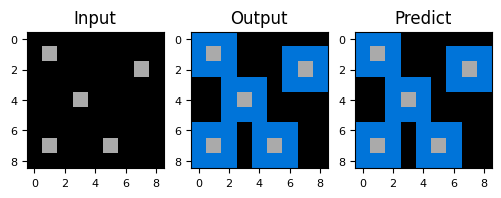

23 98 4347f46a True


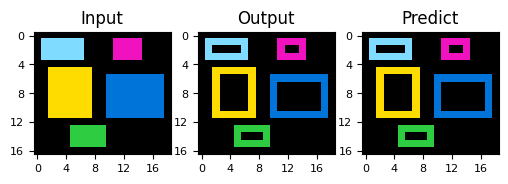

24 102 44d8ac46 False


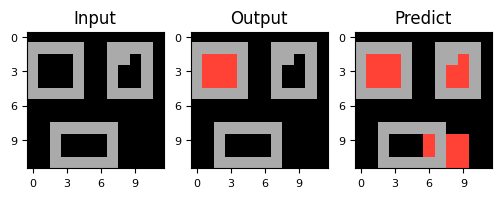

25 113 496994bd False


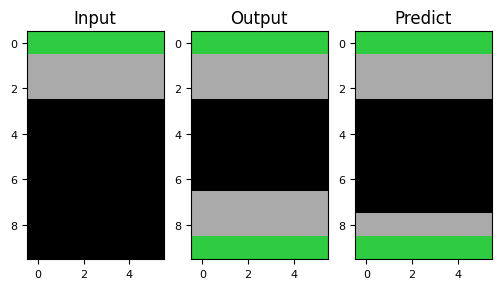

26 120 50cb2852 True


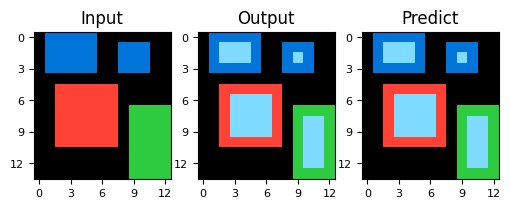

27 122 5168d44c False


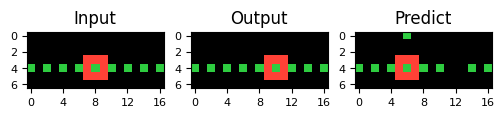

28 125 543a7ed5 True


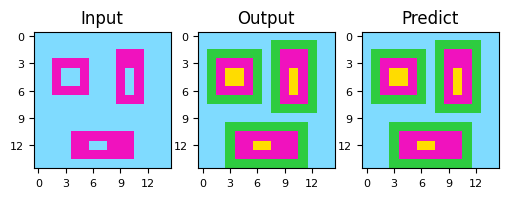

29 126 54d82841 True


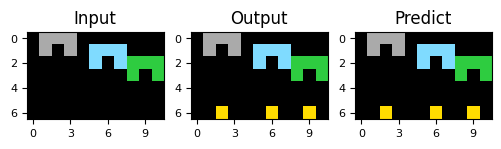

30 129 5582e5ca True


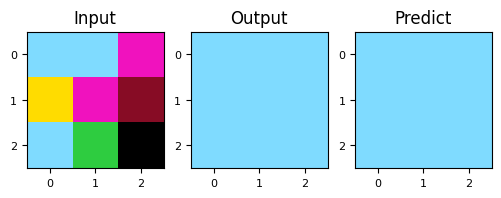

31 131 56dc2b01 False


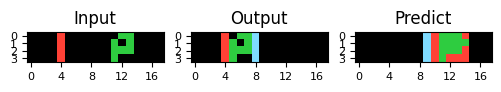

32 139 60b61512 False


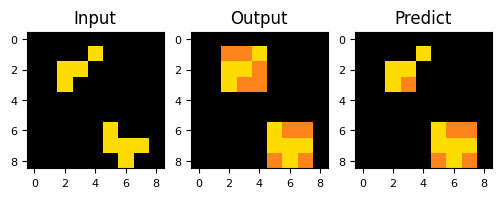

33 140 6150a2bd True


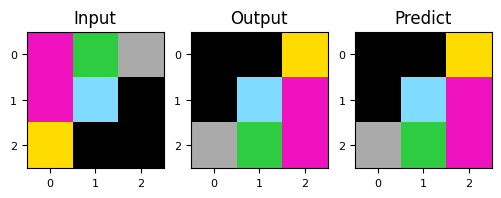

34 143 63613498 False


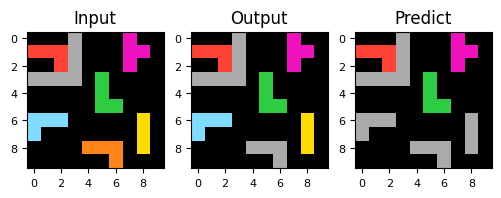

35 147 67385a82 True


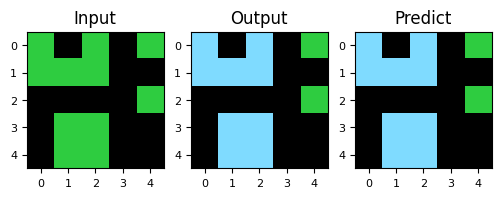

36 150 67a3c6ac True


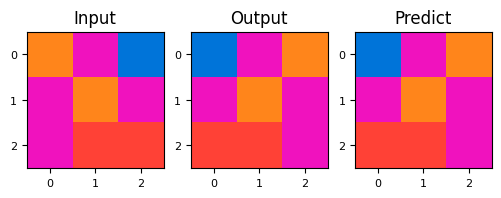

37 151 67a423a3 False


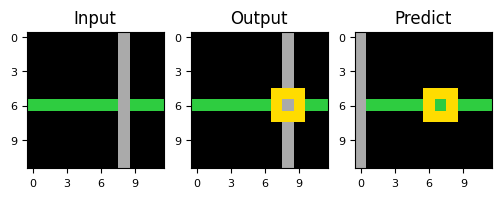

38 154 6855a6e4 True


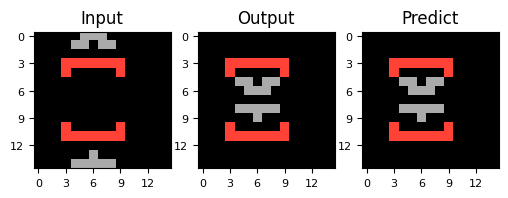

39 155 68b16354 True


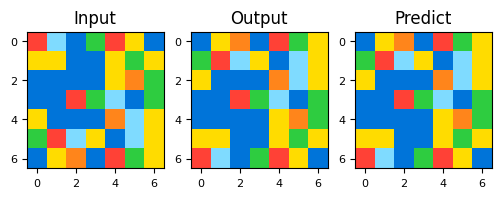

40 156 694f12f3 True


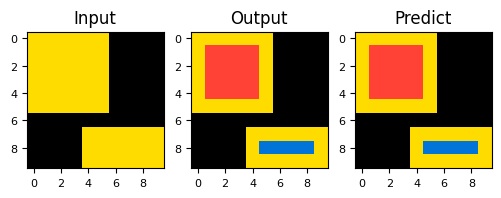

41 157 6a1e5592 False


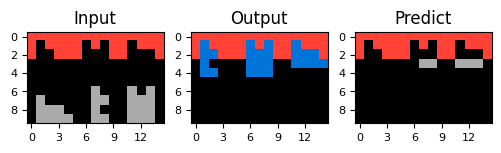

42 166 6d75e8bb True


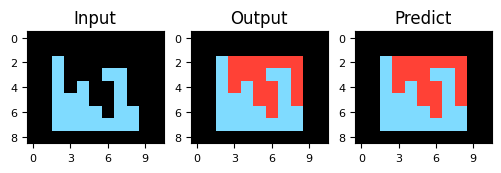

43 169 6e82a1ae True


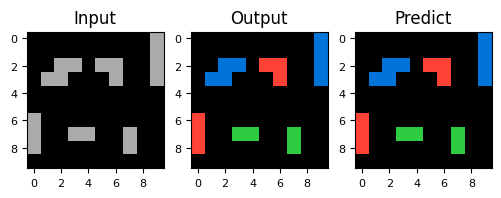

44 179 74dd1130 True


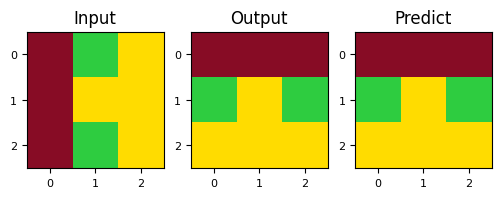

45 193 7f4411dc False


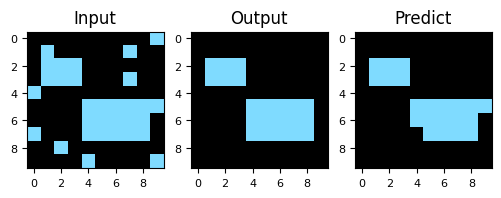

46 196 810b9b61 True


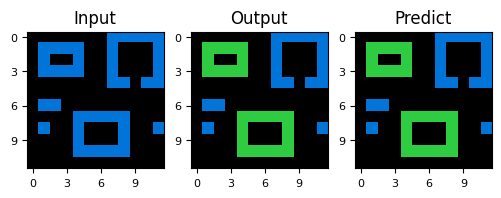

47 204 868de0fa True


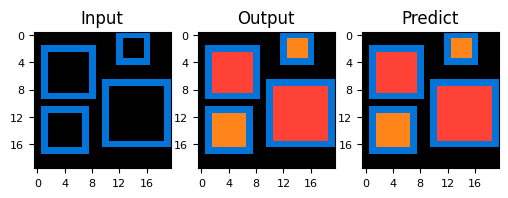

48 206 88a10436 True


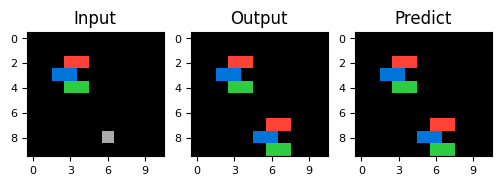

49 229 9565186b True


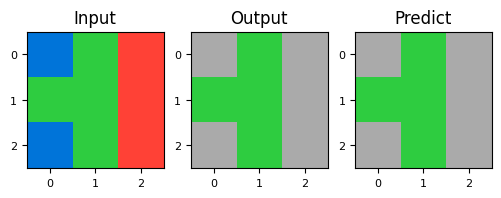

50 234 98cf29f8 False


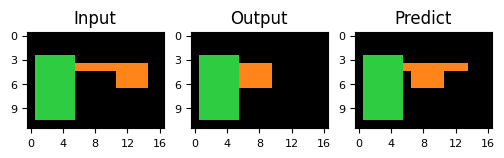

51 241 9dfd6313 True


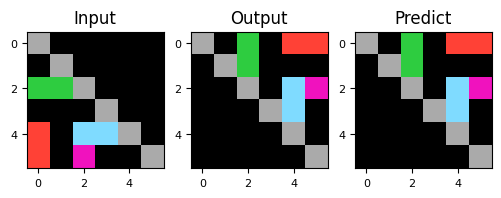

52 251 a5313dff False


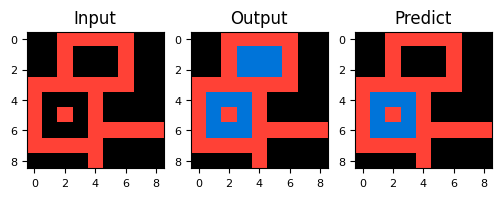

53 254 a61f2674 True


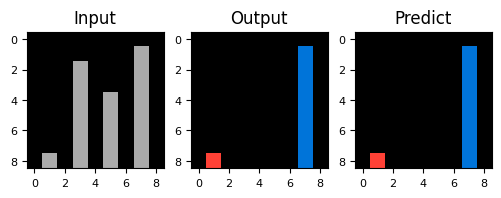

54 256 a65b410d False


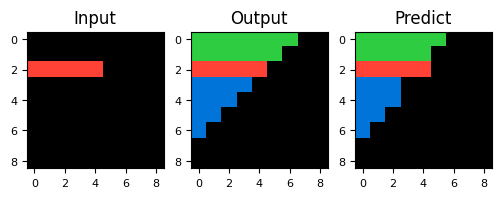

55 261 a79310a0 True


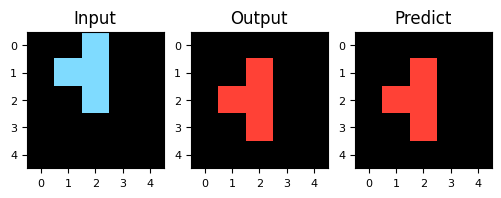

56 262 a85d4709 False


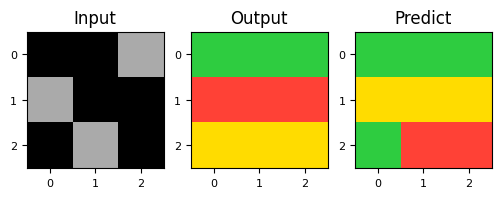

57 267 aabf363d True


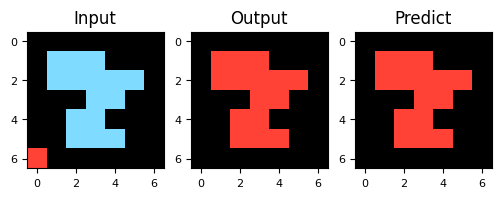

58 270 ae3edfdc True


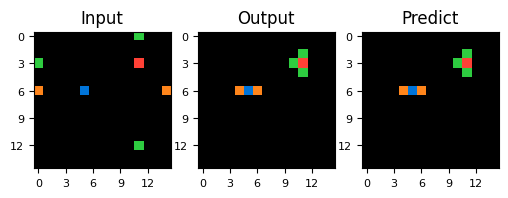

59 272 aedd82e4 True


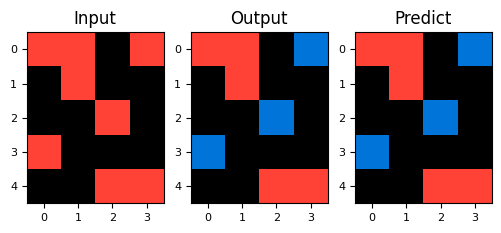

60 276 b1948b0a True


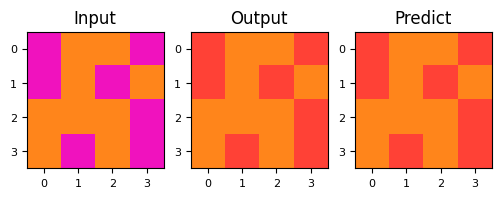

61 277 b230c067 False


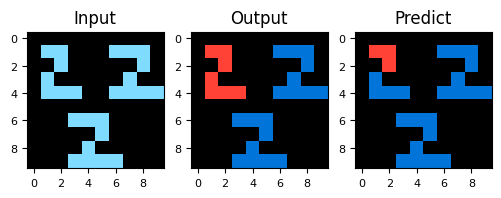

62 278 b27ca6d3 True


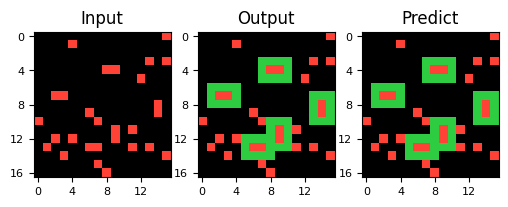

63 279 b2862040 True


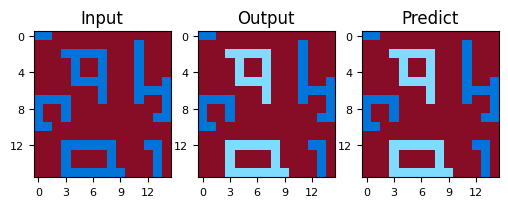

64 281 b548a754 False


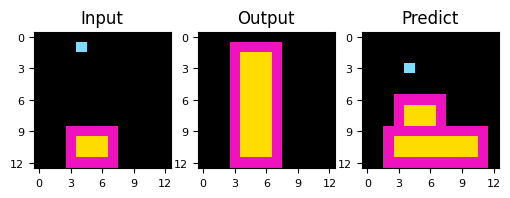

65 293 ba97ae07 True


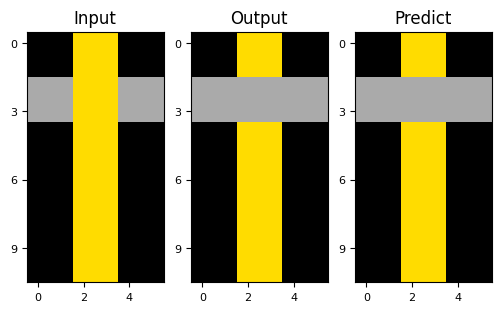

66 294 bb43febb True


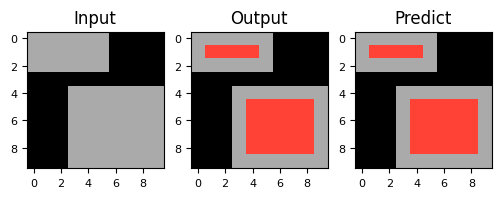

67 299 bdad9b1f False


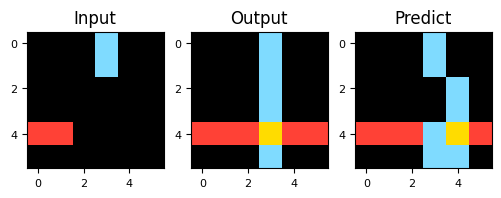

68 302 c0f76784 True


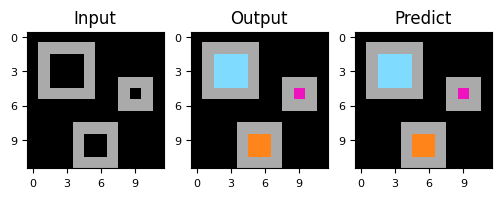

69 309 c8f0f002 True


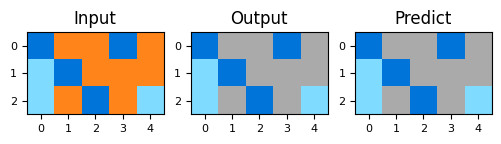

70 312 c9f8e694 True


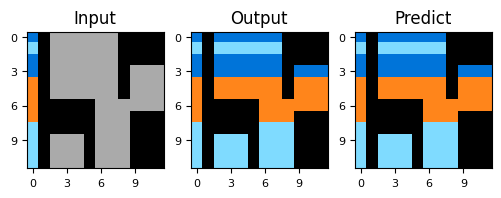

71 317 ce22a75a True


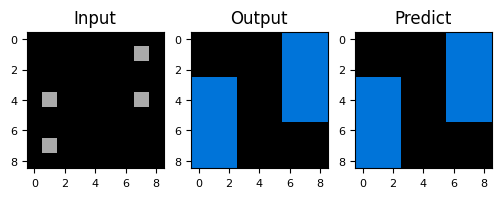

72 322 d037b0a7 True


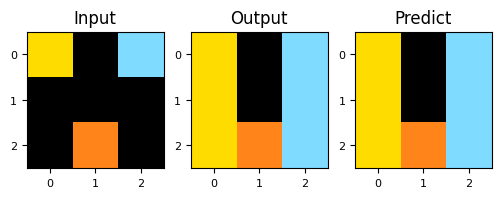

73 330 d2abd087 True


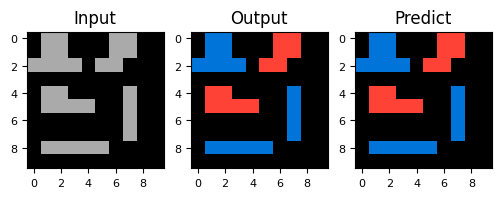

74 331 d364b489 True


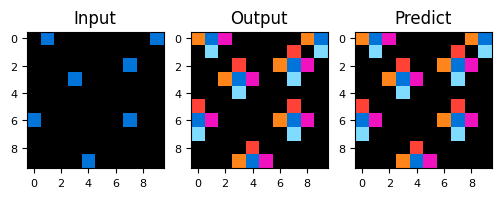

75 333 d43fd935 True


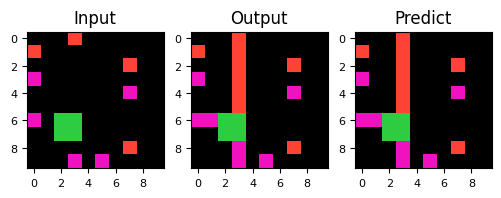

76 336 d4f3cd78 True


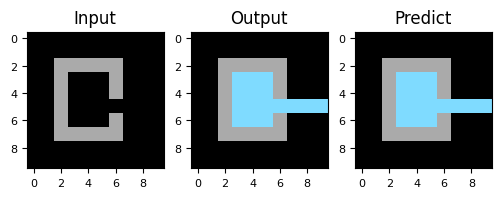

77 338 d5d6de2d True


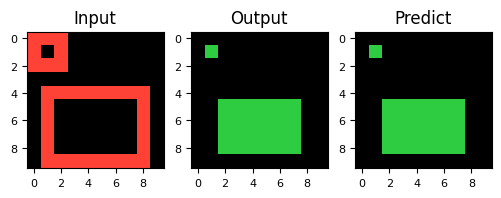

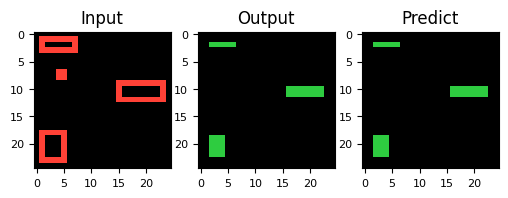

78 348 db3e9e38 False


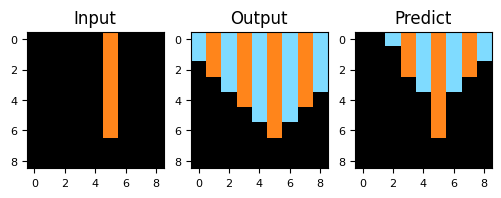

79 352 dc1df850 True


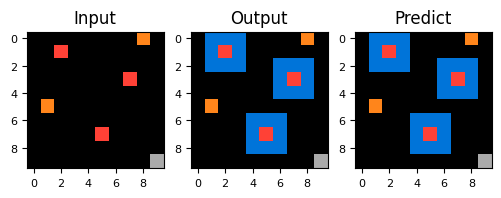

80 354 ddf7fa4f True


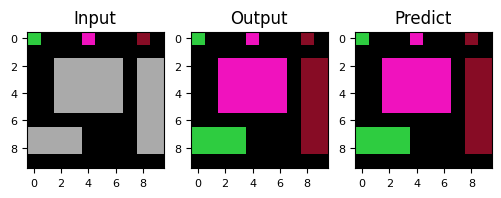

81 356 ded97339 True


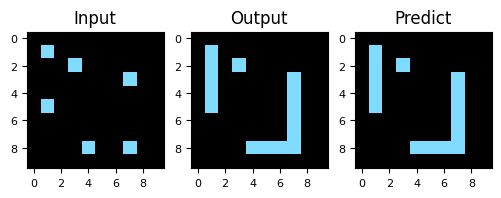

82 371 e9614598 True


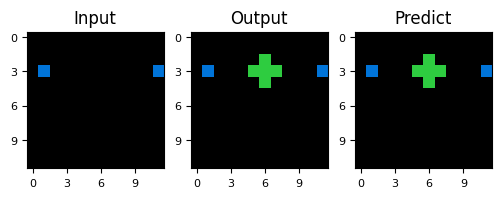

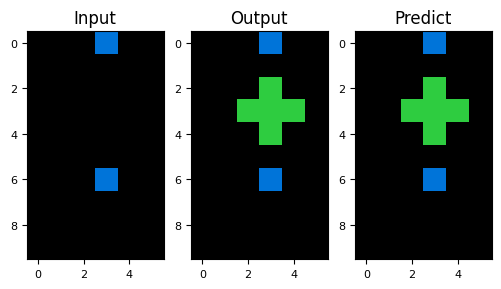

83 374 ea32f347 True


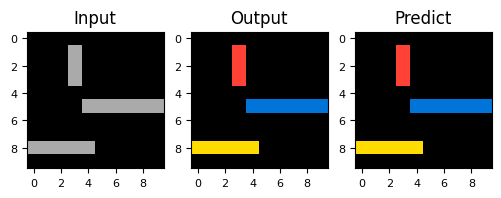

84 380 ed36ccf7 True


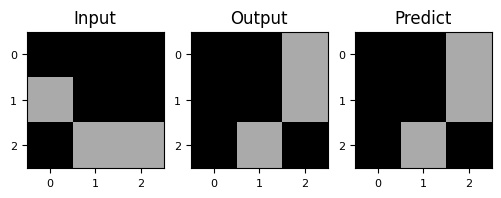

85 385 f25ffba3 False


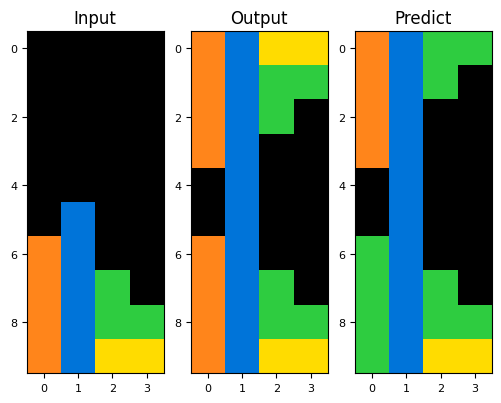

86 389 f76d97a5 False


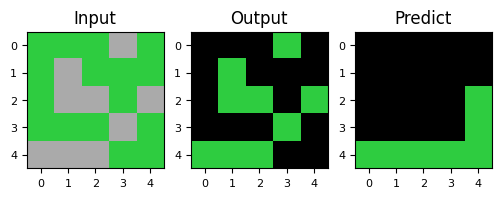

87 390 f8a8fe49 True


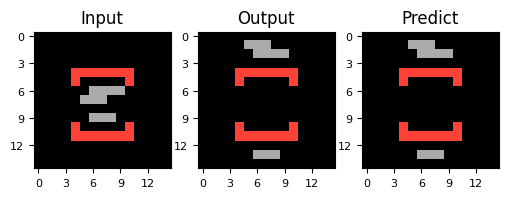

In [12]:
if '007bbfb7' in test_tasks.keys():
    observe_results(the_tasks, the_stats)